## Содержание:

### 1. Подготовка данных 

#### 1.1. Целевые ряды
#### 1.2. Ряды с событиями на станциях

### 2. Оценка потенциала прогнозируемости рядов

### 3. Множественная регрессия на одномерных рядах
#### 3.1. Формирование рядов
#### 3.2. LSTM - сеть
#### 3.3. Полносвязная сеть
#### 3.4. Сверточная сеть
#### 3.5. RandomForest и KNeighbors
#### 3.6. Предсказание средним и градиентный бустинг
#### 3.7. Визуализация предсказаний
#### 3.8. Выводы по одномерным рядам

### 4. Анализ кластерной структуры данных
#### 4.1. Работа с исходными рядами
#### 4.2. Кластеризация на новых признаках
#### 4.3. Выводы по кластерному анализу

### 5. Многомерные ряды. Обогащение данных
#### 5.1. Обогащение событийными данными
#### 5.2. LSTM на событийных рядах
#### 5.3. Random Forest на событийных рядах 
#### 5.4. Обогащение данных tsfresh
#### 5.5. Объединение tsfresh и событийных данных
#### 5.6. Сравнение результатов для одномерных и обогащенных данных
#### 5.7. Сравнение с gluonts

### 6. Общие выводы


In [158]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import keras
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,r2_score,mean_squared_error,mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

### 1. Подготовка данных 
Используем полученные данные для группировки рядов по интервалам в 4 часа

#### 1.1. Целевые ряды.
Группируем по интревалам в 4 часа данные по количеству вагонов по направлениям

In [2]:
# Загрузим данные основные в data и выше полученные фильтрацией df_include.csv
data = pd.read_csv('statistics-07-20.csv', sep = ';')
data.operation_date = pd.to_datetime(data.operation_date)

df_includes = pd.read_csv("df_includes.csv")
df_includes.operation_date = pd.to_datetime(df_includes.operation_date)

In [3]:
def make_time_series(df_includes, time_step = '4h'):
    '''
    Группирует временной кол-ва вагонов в интервале time_step для 
    ключей (станция операции, станция назначения)
    '''
    # Вытаскиваем назначение из индекса поезда
    df_includes['dest'] = [int(str(x)[-8:-2]) for x in df_includes.index_train]
    df_includes['res'] = 1
    df_res = []
    # Группируем по станции отправления и станции назначения
    dg = df_includes.groupby(by = ['operation_st_esr','dest'])
    data_to_pred = np.array([])
    # Минимальное время операции во всех данных
    start = data.operation_date.min()
    # Максимальное время старта операции во всех данных
    end = data.operation_date.max()
    for key,group in tqdm(dg):
        # вытаскиваем срез по (станция операции, станция назначения)
        df_i = dg.get_group(key)
        # добавляем две любых записи и записываем туда минимальное и максимальное время, 
        # чтобы все интревалы вышли одинаковыми
        ds_i = df_i.iloc[0,:]
        ds_i.operation_date = start
        df_i = df_i.append(ds_i)
        ds_i = df_i.iloc[0,:]
        ds_i.operation_date = end
        df_i = df_i.append(ds_i)
        #df_i.index = df_i['operation_date']
        # Суммириуем количество записей по интервалам
        res_data = df_i.resample(time_step, on = 'operation_date').agg({"res":"count"})
        # Убираем две лишних записи - в начале и в конце
        res_data.iloc[0]-=1
        res_data.iloc[-1]-=1
        # Сохраняем агрегированные признаки в выходной массив
        if data_to_pred.shape[0] == 0:
            data_to_pred = np.hstack((df_i.iloc[0][['operation_st_esr','dest']].values,res_data.res.values))
        else:
            data_to_pred = np.vstack((data_to_pred,np.hstack((df_i.iloc[0][['operation_st_esr','dest']].values,res_data.res.values))))
        df_res.append(df_i)
    return data_to_pred,df_res

In [4]:
df_includes.head()

,Unnamed: 0,index_train,length,car_number,destination_esr,adm,danger,gruz,loaded,operation_car,...,operation_st_id,operation_train,receiver,rodvag,rod_train,sender,ssp_station_esr,ssp_station_id,tare_weight,weight_brutto
0,0,9.401053e+14,0.87,51230811,953504.0,NaN,0.0,211056.0,1.0,4.0,...,2.000038e+09,71.0,7780685.0,70.0,30.0,8611364.0,940006.0,2.000038e+09,NaN,3246.0
1,0,9.535041e+14,0.87,51230811,932207.0,NaN,0.0,211056.0,2.0,4.0,...,2.000038e+09,5.0,48134187.0,70.0,72.0,15199450.0,953701.0,2.000038e+09,NaN,227.0
2,0,9.322077e+14,0.87,51230811,932300.0,NaN,0.0,211056.0,2.0,4.0,...,2.000037e+09,5.0,48134187.0,70.0,50.0,15199450.0,932207.0,2.000037e+09,NaN,1812.0
3,0,9.323009e+14,0.87,51230811,289054.0,NaN,0.0,211030.0,1.0,4.0,...,2.000037e+09,5.0,79060956.0,70.0,52.0,48134187.0,932300.0,2.000037e+09,NaN,6272.0
4,0,9.401053e+14,0.87,57510596,960007.0,NaN,0.0,211056.0,1.0,4.0,...,2.000038e+09,71.0,7780685.0,70.0,30.0,8611364.0,940006.0,2.000038e+09,NaN,3246.0


In [5]:
%%time
# Создаём искомые временные ряд|ы
data_to_pred,df_res = make_time_series(df_includes,time_step = '4h')
print("Пример полученного ряда:")
print(data_to_pred[15])

  0%|                                                                                         | 0/3652 [00:00<?, ?it/s]C:\Users\ivanov.evgeny\AppData\Roaming\Python\Python37\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
100%|██████████████████████████████████████████████████████████████████████████████| 3652/3652 [00:59<00:00, 61.15it/s]


Пример полученного ряда:
[830200.0 830304 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]
Wall time: 1min


#### 1.2. Ряды с событиями на станциях.
Формируем дополнительные данные по информации о событиях на станциях:  

DRIVEWAY_EVENT - подача на подъездной путь;   
CHANGE_DESTINATION_EVENT - измненение направление вагона;    
TRAIN_DISPATCH_EVENT - отправление вагона с поездом;   
ARRIVAL_EVENT - прибытие вагона на станцию

In [6]:
event_data = pd.read_csv("transformed.csv")
event_data.head()

,Unnamed: 0,Unnamed: 0.1,car_number,operation_st_esr,destination_esr,operation_date,event_id
0,1245800,2831679,57328866,940006.0,941600.0,2020-07-01 00:00:00,ARRIVAL_EVENT
1,947703,2853078,51038883,940006.0,941600.0,2020-07-01 00:00:00,ARRIVAL_EVENT
2,933628,2851768,51230811,940006.0,941600.0,2020-07-01 00:00:00,CHANGE_DESTINATION_EVENT
3,3494316,2853169,51203347,940006.0,941600.0,2020-07-01 00:00:00,ARRIVAL_EVENT
4,3494310,2853169,51203347,940006.0,941600.0,2020-07-01 00:00:00,CHANGE_DESTINATION_EVENT


In [7]:
# Надо нарезать для каждой станции отправления ряды с колиечством каждой event_id
events_names = event_data.event_id.value_counts().index    # имена всех операций
unqie_station = event_data.operation_st_esr.value_counts().index    #все станции операций
events_names

Index(['ARRIVAL_EVENT', 'CHANGE_DESTINATION_EVENT', 'DRIVEWAY_EVENT',
       'TRAIN_DISPATCH_EVENT'],
      dtype='object')

In [8]:
event_data = pd.read_csv("transformed.csv")

In [9]:
def make_event_data(event_data,time_interval = '4h'):  
    event_data.operation_date = pd.to_datetime(event_data.operation_date)
    event_data['res']=1
    data_event = {}
    dg = event_data.groupby(by = ['operation_st_esr'])
    events_names = event_data.event_id.value_counts().index
    start = data.operation_date.min()
    # Максимальное время старта операции во всех данных
    end = data.operation_date.max()
    i = 1
    for key,group in tqdm(dg):
        df_i = dg.get_group(key)
        #print(key)
        i = 1
        if i >2 :
            break
        # чтобы все интревалы вышли одинаковыми
        for event in events_names:
            mask = df_i.event_id == event
            #print(event)
            df_i_ev = df_i[mask]
            #print(df_i_ev.shape)
            if df_i_ev.shape[0] > 0:
                ds_i = df_i_ev.iloc[0,:]
                ds_i.operation_date = start
                df_i_ev = df_i_ev.append(ds_i)
                ds_i = df_i_ev.iloc[0,:]
                ds_i.operation_date = end
                df_i_ev = df_i_ev.append(ds_i)
                #print(df_i.tail())
                    #df_i.index = df_i['operation_date']
                    # Суммириуем количество записей по интервалам
                res_data = df_i_ev.resample(time_interval, on = 'operation_date').agg({"res":"count"})
                res_data.iloc[0]-=1
                res_data.iloc[-1]-=1   
                i = i +1
                #if i>4:
                 #   break
                #print(key)
                if data_event.get(key) is None:
                    data_event[key] = res_data.res.values
                else:
                    data_event[key] = np.vstack((data_event[key],res_data.res.values))
            else:
                if data_event.get(key) is None:
                    data_event[key] = np.zeros((1,186))
                else:
                    #print(data_event[key].shape)
                    data_event[key] = np.vstack((data_event[key],np.zeros((1,186))))
    return data_event

In [10]:
data_event= make_event_data(event_data)

  0%|                                                                                          | 0/744 [00:00<?, ?it/s]C:\Users\ivanov.evgeny\AppData\Roaming\Python\Python37\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
100%|████████████████████████████████████████████████████████████████████████████████| 744/744 [00:29<00:00, 25.45it/s]


Посмотрим на примеры рядов для предсказаний

In [11]:
# Срез данных с более чем 100 заполненными значениями
res = [sum(x>0)>50 for x in data_to_pred[:,2:]]
dpl = data_to_pred[res,:]

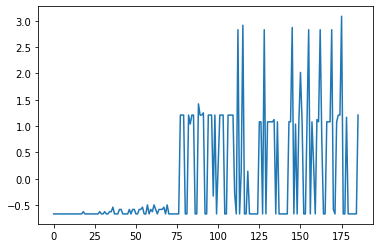

In [12]:
# Пример полученного ряда
plt.plot(range(0,dpl[0][2:].shape[0]),StandardScaler().fit_transform(dpl[13][2:].reshape(-1,1)))

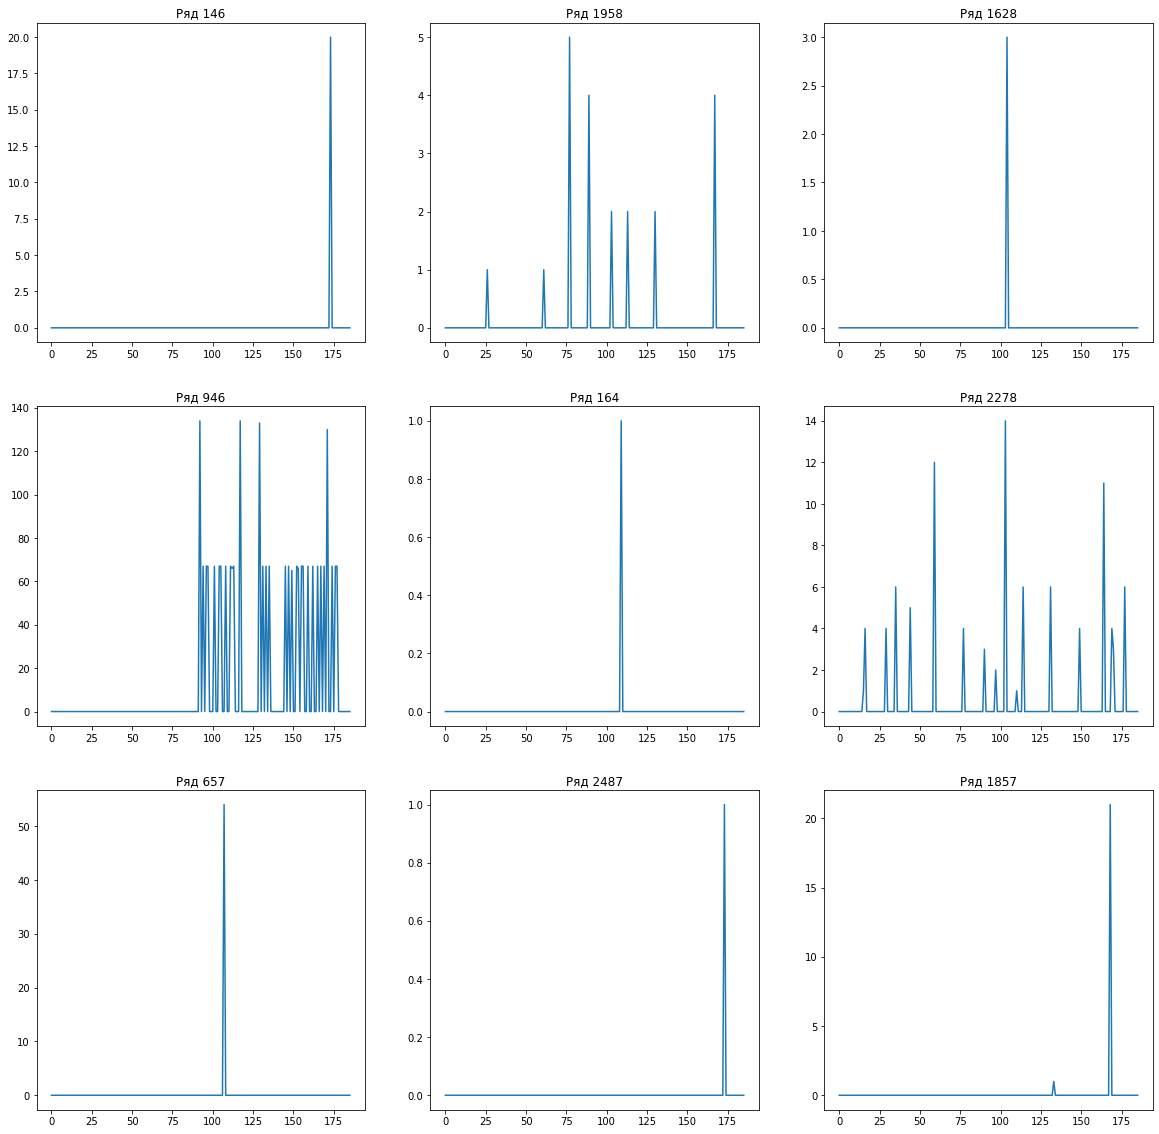

In [22]:
#Пример всех рядов, в том числе разреженных рассматриваемых рядов
fig, axes = plt.subplots(nrows=3, ncols=3,figsize = (20,20))
ind = np.random.randint(0,39,9)
for ax in axes.flatten():
    ind = np.random.randint(0,data_to_pred.shape[0])
    ax.plot(range(0,data_to_pred[0][2:].shape[0]),data_to_pred[ind][2:].reshape(-1,1))
    ax.set(title = f'Ряд {ind}')



(array([110.,   7.,   9.,   8.,   9.,   8.,   9.,   1.,   2.,   4.,   4.,
          2.,   2.,   5.,   0.,   1.,   2.,   1.,   1.,   1.]),
 array([-0.63707782, -0.41434008, -0.19160235,  0.03113538,  0.25387311,
         0.47661085,  0.69934858,  0.92208631,  1.14482405,  1.36756178,
         1.59029951,  1.81303724,  2.03577498,  2.25851271,  2.48125044,
         2.70398817,  2.92672591,  3.14946364,  3.37220137,  3.5949391 ,
         3.81767684]),
 <a list of 20 Patch objects>)

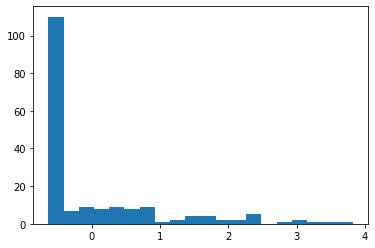

In [20]:
# Распределение ряда
plt.hist(StandardScaler().fit_transform(dpl[22][2:].reshape(-1,1)),bins = 20)

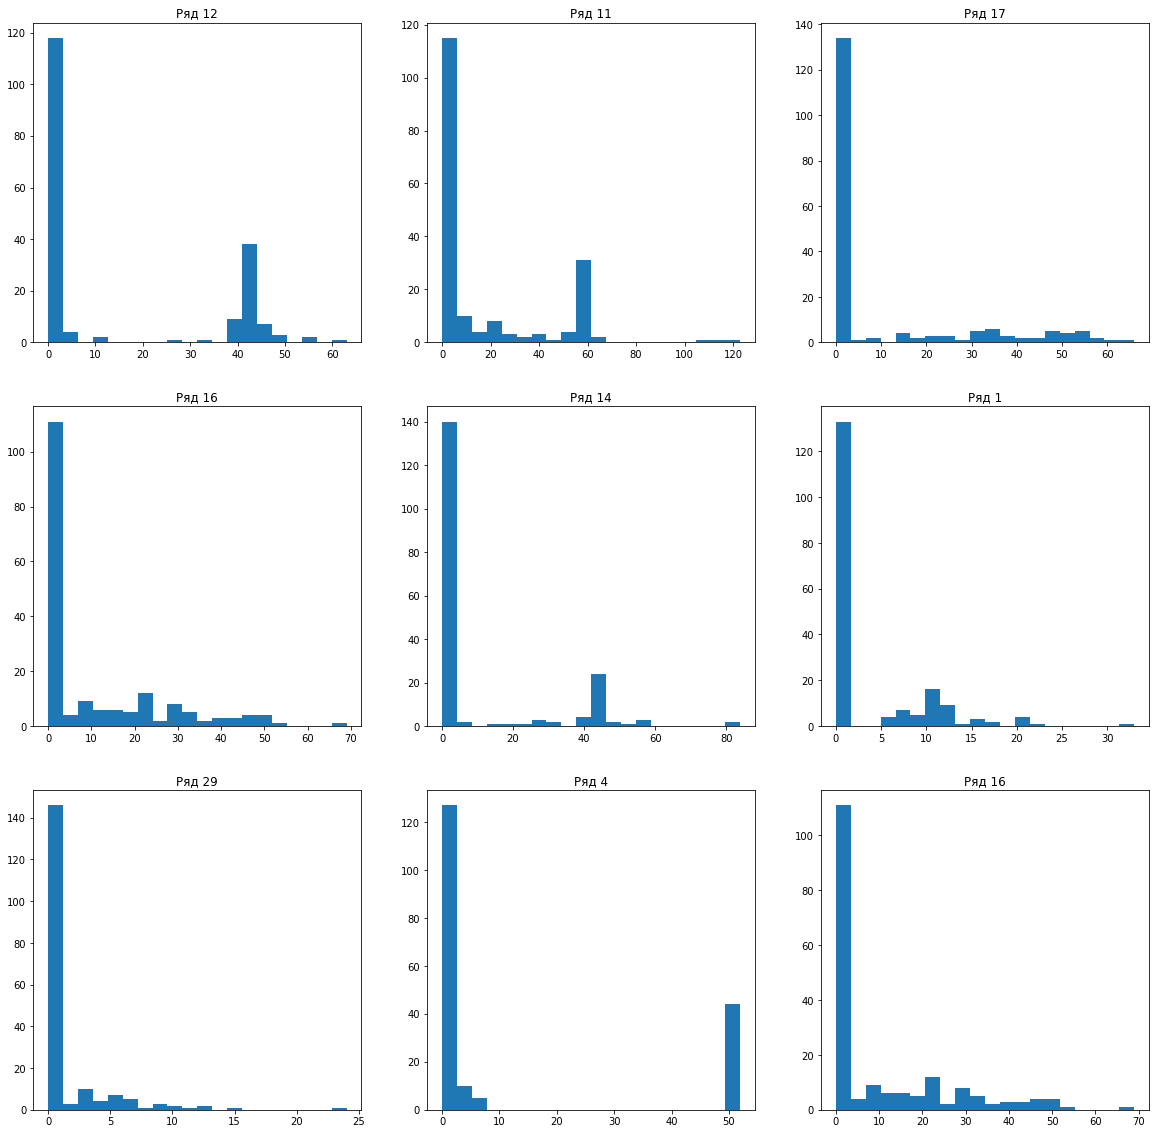

In [23]:
#Пример рассматриваемых рядов
fig, axes = plt.subplots(nrows=3, ncols=3,figsize = (20,20))
ind = np.random.randint(0,39,9)
for ax in axes.flatten():
    ind = np.random.randint(0,39)
    ax.hist(dpl[ind][2:].reshape(-1,1),bins = 20)
    #ax.plot(range(0,dpl[0][2:].shape[0]),dpl[ind][2:].reshape(-1,1))
    ax.set(title = f'Ряд {ind}')


In [16]:
# Отсеим разреженные ряды и работать будем с теми, для которых данные есть
print(f"Всего рядов : {data_to_pred.shape[0]}")
print(f"Кол-во рассматриваемых рядов : {data_to_pred[[sum(x>0)>50 for x in data_to_pred[:,2:]],2:].shape[0]}")
# Оценим кол-во вагонов рассматриваемых и отсеянных при рассмотрении для фильтра в 50 записей
print(f"Кол-во рассматриваемых вагонов : {sum(sum(data_to_pred[[sum(x>0)>50 for x in data_to_pred[:,2:]],2:]))}")
print(f"Кол-во нерассматриваемых вагонов: {sum(sum(data_to_pred[[sum(x>0)<=50 for x in data_to_pred[:,2:]],2:]))}")

Всего рядов : 3652
Кол-во рассматриваемых рядов : 39
Кол-во рассматриваемых вагонов : 84216
Кол-во нерассматриваемых вагонов: 417634


In [17]:
#Сохраним файл со всеми рядами, кол-во имеющихся записей которых хотя бы > 50 - их используем для предсказаний
res = [sum(x>0)>50 for x in data_to_pred[:,2:]]
res_data = data_to_pred[res,:]
print(res_data.shape)
np.save('data_all.npy',data_to_pred[res,:])

(39, 188)


In [18]:
# Здесь уже делаем многомерный ряд для всех рядов с заполненными более 50 значениями
ndim_data = []
for op_st,dest_st,data_var in [(z[0],z[1],z[2:]) for z in res_data]:
    ev_data_op_st = data_event.get(op_st,np.zeros((4,186)))
    ev_data_dest_st = data_event.get(op_st,np.zeros((4,186)))
    ndim_data.append(np.vstack((data_var,ev_data_op_st,ev_data_dest_st)))
ndim_data = np.array(ndim_data)
ndim_data[0,:,:].shape

(9, 186)

### 2. Оценка потенциала прогнозируемости рядов

https://ru.wikipedia.org/wiki/Q-тест_Льюнг_—_Бокса

Q-тест Льюнг — Бокса может быть определён следующим образом. Выдвигаются две конкурирующие гипотезы:

H_0: данные являются случайными (то есть представляют собой белый шум).   
H_a: данные не являются случайными.

 Критерий не теряет своей состоятельности, даже если процесс не имеет нормального распределения (при наличии конечной дисперсии)

In [46]:
# Тесты Льюинга-Бокса для проверки некоррелированности рядов
import statsmodels.api as sm

print("Минимальное значение p-value для теста Льюинга-Бокса на всех лагах для рассматриваемых рядов:")
pval_min = [np.min(sm.stats.acorr_ljungbox(StandardScaler().fit_transform(dpl[i][2:].reshape(-1,1)))[1]) for i in range(0,dpl.shape[0])]
pval_min

Минимальное значение p-value для теста Льюинга-Бокса на всех лагах для рассматриваемых рядов:


[9.915182210063234e-74,
 5.2728273772944325e-34,
 0.003222512943492775,
 0.002151041194037038,
 3.715333587435291e-22,
 3.502970979875424e-27,
 0.44167529543698725,
 0.13774633296002828,
 0.000345845418921576,
 0.1857510059935482,
 0.17930008313356904,
 1.7040398593768017e-05,
 1.1346599805472066e-62,
 5.838026873186633e-49,
 0.0007158038818938029,
 0.005572407106106785,
 0.0002567414057379844,
 0.06704544620096392,
 0.30026493874858273,
 0.10429887649268305,
 0.23316309557012607,
 0.010778037495226605,
 0.010111040980595572,
 0.004374670448104493,
 0.053469238152482015,
 7.309683732433494e-30,
 0.0036832369114532804,
 0.1490684947978005,
 0.02344000149892581,
 0.16491182990078102,
 0.024120855151376453,
 6.15957647170213e-06,
 0.44271398763735026,
 2.4629358234109756e-12,
 0.028155799108908836,
 0.01706955344643263,
 0.03688807974115998,
 0.4052654305872806,
 3.628572296390846e-05]

In [47]:
print(f"Кол-во рядов с p_val>0.05 = {sum(np.array(pval_min)>0.05)}")

Кол-во рядов с p_val>0.05 = 13


Как бы все плохо - треть рядов являются белым шумом, так как значение p-value достаточно высоко и опровергнуть нулевую гипотезу о неслучайности ряда нельзя. 
Это всё будет видно в дальнейшем анализе-как в отсутствии кластерной структруы, так и в отсутствии обобщающей сопособности моделей, примененных для предсказаний.

### 3. Множественная регрессия на одномерных рядах

Начнем пробовать строить модели для полученных рядов - начнем с множественной регрессии без добавления новых признаков на 12 точек вперед, что соответствует предсказанию на 2 дня вперед. Размер окна для предсказаний выбран равным 32 точкам.
Контрольным рядом возьмем 14 в нашей выборке - у него хоть какая-то структура есть и потенциал для прогнозирования. Метрики будем смотреть сразу 3 - mse использовать при обучении сетей, отслеживать при этом MAE, а сравнивать модели по R^2
#### 3.1. Формирование рядов

In [216]:
def get_roll_data(data,roll_window,num_pred):
    '''
    data - временной ряд , np.array
    roll_window - размер окна для предсказания, int
    num_pred - кол-во предсказываемых позиций, int
    return нарезанный по окнам ряд с метками для предсказаний
    '''
    ind_start = roll_window
    ind_stop = data.shape[0] - roll_window - num_pred
    data_roll = np.zeros((ind_stop+1,roll_window))
    labels_roll = np.zeros((1,num_pred))
    for i in range(0,ind_stop+1):
        data_roll[i,:] = np.array(data[i:i +roll_window]).astype(float).reshape((1,roll_window))
        labels_roll = np.vstack((labels_roll,np.array(data[i+roll_window:i+roll_window+num_pred]).astype(float).reshape((1,num_pred))))
    return data_roll,labels_roll[1:]

In [217]:
def get_train_test_transform_without_intersectioin(data,roll_window,num_pred,test_size):
    '''
    Функция режет временной ряд на интервалы без train и test без пересечения оных - отсутствует утечка данных 
    
    args:
    data - временной ряд, используются позиции с 3-ей 
    считается что две первые позиции - зарезервированы под ключи ряда по операциям
    roll_window - размер окна для обучения
    num_pred - кол-во предсказываемых последовательных позиций ряда
    test_size - размер выборки под валидацию
    
    return X_train,X_test,y_train,y_test,sc
    sc - использованный обученный StandatScaler
    '''
    dt = data[2:]
    key_dt = data[1:2]
    data_train = dt[:int(data.shape[0]*(1-test_size))]
    data_test = dt[int(data.shape[0]*(1-test_size)):]
    #print(int(data.shape[0]*(1-test_size)))
    sc = StandardScaler()
    data_train_sc = sc.fit_transform(data_train.reshape(-1,1))
    data_test_sc = sc.transform(data_test.reshape(-1,1))
    # блок нарезки на окна
    X_train,y_train = get_roll_data(data_train_sc,roll_window,num_pred)
    X_test,y_test = get_roll_data(data_test_sc,roll_window,num_pred)
    return X_train,X_test,y_train,y_test,sc

In [218]:
def get_train_test_transform_with_intersectioin(data,roll_window,num_pred,test_size):
    '''
    Функция режет временной ряд на интервалы без train и test с пересечением - возможна утечка данных 
    
    args:
    data - временной ряд, используются позиции с 3-ей 
    считается что две первые позиции - зарезервированы под ключи ряда по операциям
    roll_window - размер окна для обучения
    num_pred - кол-во предсказываемых последовательных позиций ряда
    test_size - размер выборки под валидацию
    
    return X_train,X_test,y_train,y_test,sc
    sc - использованный обученный StandatScaler
    
    '''
    
    dt = data[2:]
    key_dt = data[1:2]
    data_train = dt[:int(dt.shape[0]*(1-test_size))+roll_window+num_pred-1]
    data_test = dt[int(dt.shape[0]*(1-test_size)):]
    #print(dt.shape)
    #print(int(data.shape[0]*(1-test_size)))
    sc = StandardScaler()
    data_train_sc = sc.fit_transform(data_train.reshape(-1,1))
    data_test_sc = sc.transform(data_test.reshape(-1,1))
    # блок нарезки на окна
    X_train,y_train = get_roll_data(data_train_sc,roll_window,num_pred)
    X_test,y_test = get_roll_data(data_test_sc,roll_window,num_pred)
    return X_train,X_test,y_train,y_test,sc

In [219]:
def plot_history(history,epoch,metrics = "MAE"):
      '''
      Рисует графики точности и ошибки на train/valid
      history - from model.fit
      epochs - num of epochs in fitting model
      '''

      acc = history.history[metrics]
      val_acc = history.history['val_'+metrics]

      loss = history.history['loss']
      val_loss = history.history['val_loss']

      epochs_range = range(epoch)

      plt.figure(figsize=(15, 8))
      plt.subplot(1, 2, 1)
      plt.plot(epochs_range, acc, label='Training Accuracy')
      plt.plot(epochs_range, val_acc, label='Validation Accuracy')
      plt.legend(loc='lower right')
      plt.title('Training and Validation Accuracy')

      plt.subplot(1, 2, 2)
      plt.plot(epochs_range, loss, label='Training Loss')
      plt.plot(epochs_range, val_loss, label='Validation Loss')
      plt.legend(loc='upper right')
      plt.title('Training and Validation Loss')
      plt.show()

In [220]:
def plot_results(model,testX,trainX,num_pred,):
    y_pred_test = [model.predict(testX[i][np.newaxis,:,:]) for i in range(0,testX.shape[0])]
    y_pred_train = [model.predict(trainX[i][np.newaxis,:,:]) for i in range(0,trainX.shape[0])]
    plt.figure(figsize=(15,8))
    plt.title('Работа модели на представленных данных')
   
    plt.plot(range(0,3*num_pred),np.hstack((y_train[-3*num_pred+1],y_train[-3*num_pred+1],y_train[-num_pred+1])),'k')
    plt.plot(range(0,3*num_pred),np.hstack((y_pred_train[-3*num_pred+1],y_pred_train[-2*num_pred+1],y_pred_train[-num_pred+1])).reshape((36,)),'g',label = 'train')
    plt.plot(range(3*num_pred-1,3*num_pred-1 + 3*num_pred),np.hstack((y_test[0],y_test[1],y_test[2])),'k')
    plt.plot(range(3*num_pred-1,3*num_pred-1 + 3*num_pred),np.hstack((y_pred_test[0],y_pred_test[1],y_pred_test[2])).reshape((36,)),'m',label = 'test')
    plt.legend(loc='upper right')
    plt.show()

Формируем ряды для проверки моделей

In [144]:
roll_w = 32
num_pred = 12
test_size = 0.3
tsd = res_data[13]
X_train,X_test,y_train,y_test,scaler = get_train_test_transform_with_intersectioin(tsd,roll_w,num_pred,test_size)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(130, 32) (13, 32)
(130, 12) (13, 12)


#### 3.2. LSTM - сеть

In [145]:
trainX = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
testX = np.reshape(X_test, (X_test.shape[0],  X_test.shape[1],1))
print(trainX.shape)

(130, 32, 1)


In [146]:
%%time

# create and fit the LSTM network
model = keras.models.Sequential()
#model.add(keras.layers.Input(shape=(32, 1)))
model.add(keras.layers.Input(batch_shape=(1,32, 1)))
model.add(keras.layers.LSTM(40,return_sequences=True,stateful=True,activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256,activation = 'relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(64,activation = 'relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(12,activation=None))
optim = keras.optimizers.Adam(learning_rate = 1e-3)

model.compile(loss='mse',optimizer = optim,metrics=['MAE'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, 32, 40)               6720      
_________________________________________________________________
batch_normalization (BatchNo (1, 32, 40)               160       
_________________________________________________________________
dropout (Dropout)            (1, 32, 40)               0         
_________________________________________________________________
flatten (Flatten)            (1, 1280)                 0         
_________________________________________________________________
dense (Dense)                (1, 256)                  327936    
_________________________________________________________________
dropout_1 (Dropout)          (1, 256)                  0         
_________________________________________________________________
dense_1 (Dense)              (1, 64)                   1

In [147]:
epochs = 40
history = model.fit(trainX, y_train, epochs=epochs, batch_size=1, verbose=2,validation_data=(testX,y_test))
#plot_history(history,epochs,metrics = "MAPE")

Epoch 1/40
130/130 - 8s - loss: 1.6832 - MAE: 1.0298 - val_loss: 1.9258 - val_MAE: 1.1643
Epoch 2/40
130/130 - 5s - loss: 1.1307 - MAE: 0.8835 - val_loss: 1.9284 - val_MAE: 1.1615
Epoch 3/40
130/130 - 5s - loss: 1.0588 - MAE: 0.8629 - val_loss: 1.8791 - val_MAE: 1.1500
Epoch 4/40
130/130 - 5s - loss: 1.0455 - MAE: 0.8578 - val_loss: 1.7566 - val_MAE: 1.1135
Epoch 5/40
130/130 - 5s - loss: 0.9946 - MAE: 0.8360 - val_loss: 1.5642 - val_MAE: 1.0267
Epoch 6/40
130/130 - 5s - loss: 0.9591 - MAE: 0.8161 - val_loss: 1.4853 - val_MAE: 1.0086
Epoch 7/40
130/130 - 5s - loss: 0.9369 - MAE: 0.8042 - val_loss: 1.3758 - val_MAE: 0.9343
Epoch 8/40
130/130 - 5s - loss: 0.9431 - MAE: 0.8015 - val_loss: 1.3867 - val_MAE: 0.9583
Epoch 9/40
130/130 - 5s - loss: 0.8868 - MAE: 0.7685 - val_loss: 1.4166 - val_MAE: 0.9732
Epoch 10/40
130/130 - 6s - loss: 0.8789 - MAE: 0.7641 - val_loss: 1.4569 - val_MAE: 0.9931
Epoch 11/40
130/130 - 5s - loss: 0.8527 - MAE: 0.7379 - val_loss: 1.3638 - val_MAE: 0.9107
Epoch 12

R2 = 0.17294020512441446
MAE = 0.8455755312407017


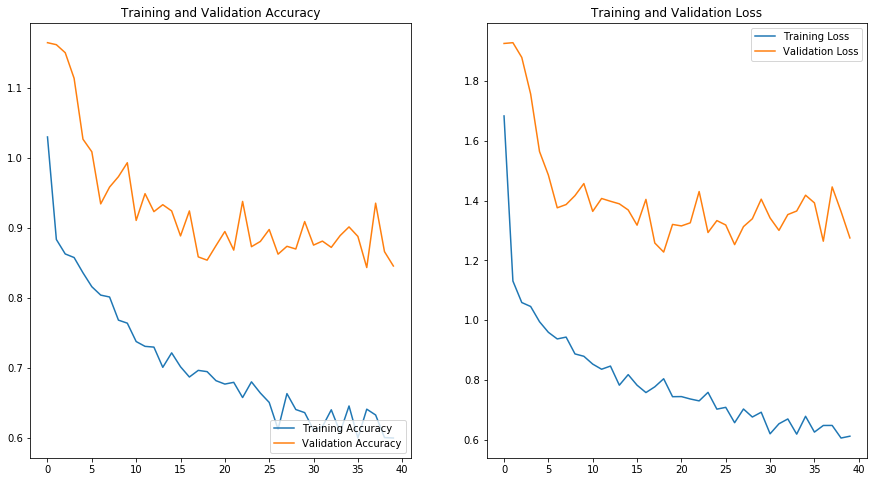

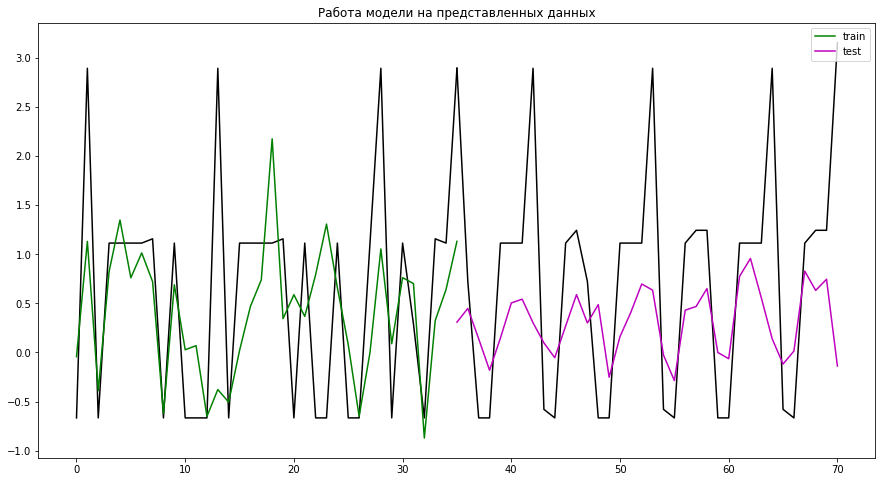

In [148]:
y_pred_test = [model.predict(testX[i][np.newaxis,:,:]) for i in range(0,testX.shape[0])]
y_pred_train = [model.predict(trainX[i][np.newaxis,:,:]) for i in range(0,trainX.shape[0])]
print(f"R2 = {r2_score(y_test,np.array(y_pred_test).reshape(y_test.shape))}")
print(f"MAE = {mean_absolute_error(y_test,np.array(y_pred_test).reshape(y_test.shape))}")
plot_history(history,epochs,metrics = "MAE")
plot_results(model,testX,trainX,num_pred)

#### 3.3. Полносвязная сеть

Рассмотрим модель только с полносвязными слоями

In [149]:
# Переформатируем тензоры
trainX = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
testX = np.reshape(X_test, (X_test.shape[0],  X_test.shape[1],1))
print(trainX.shape,y_train.shape)

(130, 32, 1) (130, 12)


In [150]:
# Модель прямого распространения с полносвязными слоями

model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(32, 1)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512,activation = 'relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(256,activation = 'relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(12,activation=None))
optim = keras.optimizers.Adam(learning_rate = 1e-3)

model.compile(loss='mse',optimizer = optim,metrics=['MAE'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               16896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 12)                3084      
Total params: 151,308
Trainable params: 151,308
Non-trainable params: 0
________________________________________________

In [151]:
epochs = 20
history = model.fit(trainX, y_train, epochs=epochs, batch_size=1, verbose=2,validation_data=(testX,y_test))

Epoch 1/20
130/130 - 1s - loss: 1.1470 - MAE: 0.8593 - val_loss: 1.6160 - val_MAE: 1.0366
Epoch 2/20
130/130 - 0s - loss: 0.8968 - MAE: 0.7362 - val_loss: 1.5200 - val_MAE: 0.9514
Epoch 3/20
130/130 - 0s - loss: 0.7875 - MAE: 0.6777 - val_loss: 1.4341 - val_MAE: 0.9068
Epoch 4/20
130/130 - 0s - loss: 0.7193 - MAE: 0.6512 - val_loss: 1.4736 - val_MAE: 0.8870
Epoch 5/20
130/130 - 0s - loss: 0.6646 - MAE: 0.6211 - val_loss: 1.4524 - val_MAE: 0.8847
Epoch 6/20
130/130 - 0s - loss: 0.6147 - MAE: 0.5954 - val_loss: 1.4649 - val_MAE: 0.9117
Epoch 7/20
130/130 - 0s - loss: 0.5691 - MAE: 0.5708 - val_loss: 1.4333 - val_MAE: 0.8666
Epoch 8/20
130/130 - 0s - loss: 0.5473 - MAE: 0.5681 - val_loss: 1.3999 - val_MAE: 0.8687
Epoch 9/20
130/130 - 0s - loss: 0.5142 - MAE: 0.5490 - val_loss: 1.4191 - val_MAE: 0.8841
Epoch 10/20
130/130 - 0s - loss: 0.4830 - MAE: 0.5316 - val_loss: 1.4121 - val_MAE: 0.9007
Epoch 11/20
130/130 - 0s - loss: 0.4731 - MAE: 0.5287 - val_loss: 1.3739 - val_MAE: 0.8647
Epoch 12

R2 = 0.09345639015218261
MAE = 0.9002465097686335


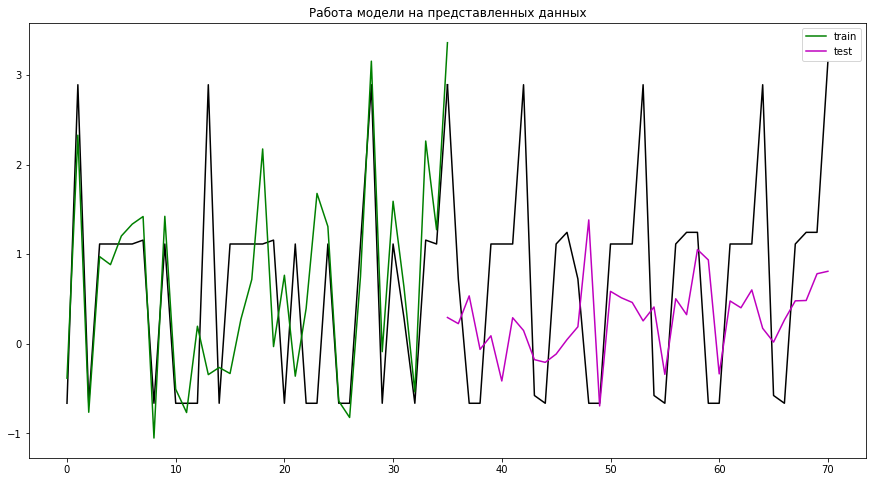

In [152]:
y_pred_test = model.predict(testX)
y_pred_train = model.predict(trainX)
print(f"R2 = {r2_score(y_test,y_pred_test)}")
print(f"MAE = {mean_absolute_error(y_test,y_pred_test)}")
plt.figure(figsize=(15,8))
plt.title('Работа модели на представленных данных')
plt.plot(range(0,3*num_pred),np.hstack((y_train[-3*num_pred+1],y_train[-3*num_pred+1],y_train[-num_pred+1])),'k')
plt.plot(range(0,3*num_pred),np.hstack((y_pred_train[-3*num_pred+1],y_pred_train[-2*num_pred+1],y_pred_train[-num_pred+1])),'g',label = 'train')
plt.plot(range(3*num_pred-1,3*num_pred-1 + 3*num_pred),np.hstack((y_test[0],y_test[1],y_test[2])),'k')
plt.plot(range(3*num_pred-1,3*num_pred-1 + 3*num_pred),np.hstack((y_pred_test[0],y_pred_test[1],y_pred_test[2])),'m',label = 'test')
plt.legend(loc='upper right')
plt.show()

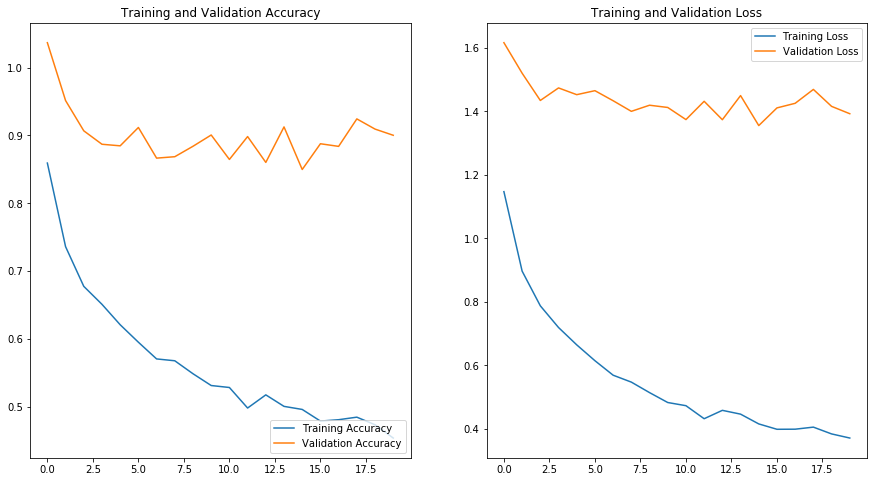

In [153]:
plot_history(history,epochs,metrics = "MAE")

#### 3.4. Сверточная сеть
Перейдем к модели со сверточными слоями

In [154]:
# Модель со сверточными слоями Conv1D
trainX = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
testX = np.reshape(X_test, (X_test.shape[0],  X_test.shape[1],1))
print(trainX.shape,y_train.shape)

(130, 32, 1) (130, 12)


In [155]:
# Модель со сверточными слоями
model = keras.models.Sequential()
#model.add(keras.layers.Input(shape=(1,32)))
#model.add(keras.layers.Input())
model.add(keras.layers.Conv1D(32, 3, activation='relu',input_shape = (32,1)))
#model.add(keras.layers.MaxPool1D(2))
model.add(keras.layers.Conv1D(32, 3, activation='relu'))
#model.add(keras.layers.MaxPool1D(2))
model.add(keras.layers.Flatten())
#model.add(keras.layers.Dense(512,activation = 'relu'))
##model.add(keras.layers.Dropout(0.5))
#model.add(keras.layers.Dense(512,activation = 'relu'))
#model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(256,activation = 'relu'))
model.add(keras.layers.Dropout(0.4))
#model.add(keras.layers.Dense(64,activation = 'relu'))
#model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(12,activation=None))
optim = keras.optimizers.Adam(learning_rate = 1e-3)

model.compile(loss='mse',optimizer = optim,metrics=['MAE'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 30, 32)            128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 28, 32)            3104      
_________________________________________________________________
flatten_2 (Flatten)          (None, 896)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               229632    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 12)                3084      
Total params: 235,948
Trainable params: 235,948
Non-trainable params: 0
________________________________________________

Epoch 1/20
130/130 - 5s - loss: 1.0568 - MAE: 0.8732 - val_loss: 1.5673 - val_MAE: 1.0873
Epoch 2/20
130/130 - 0s - loss: 0.8871 - MAE: 0.7721 - val_loss: 1.4083 - val_MAE: 0.9473
Epoch 3/20
130/130 - 0s - loss: 0.7607 - MAE: 0.6762 - val_loss: 1.4342 - val_MAE: 0.8951
Epoch 4/20
130/130 - 0s - loss: 0.6669 - MAE: 0.6322 - val_loss: 1.4024 - val_MAE: 0.8621
Epoch 5/20
130/130 - 0s - loss: 0.5554 - MAE: 0.5701 - val_loss: 1.4109 - val_MAE: 0.8350
Epoch 6/20
130/130 - 0s - loss: 0.4995 - MAE: 0.5359 - val_loss: 1.3998 - val_MAE: 0.8638
Epoch 7/20
130/130 - 1s - loss: 0.4404 - MAE: 0.5103 - val_loss: 1.4034 - val_MAE: 0.8615
Epoch 8/20
130/130 - 0s - loss: 0.3920 - MAE: 0.4709 - val_loss: 1.4143 - val_MAE: 0.8568
Epoch 9/20
130/130 - 0s - loss: 0.3550 - MAE: 0.4587 - val_loss: 1.4401 - val_MAE: 0.8842
Epoch 10/20
130/130 - 0s - loss: 0.3455 - MAE: 0.4497 - val_loss: 1.3572 - val_MAE: 0.8363
Epoch 11/20
130/130 - 0s - loss: 0.3148 - MAE: 0.4181 - val_loss: 1.3330 - val_MAE: 0.8190
Epoch 12

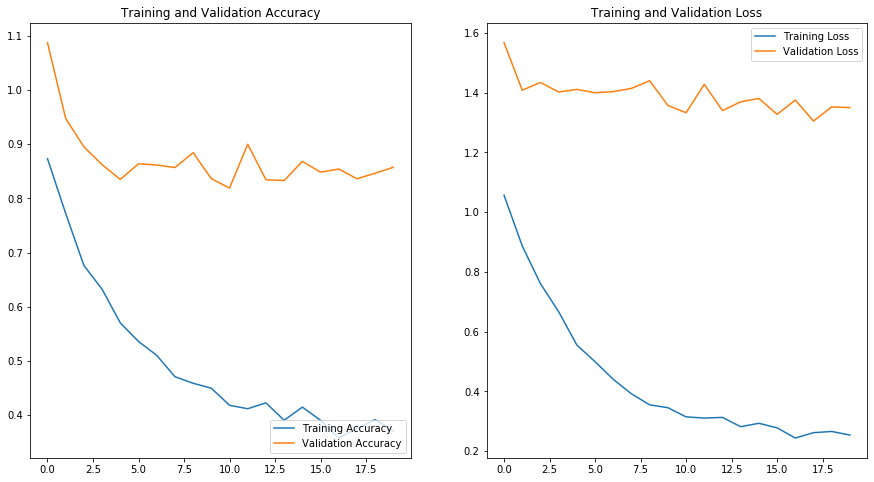

In [156]:
epochs = 20
history = model.fit(trainX, y_train, epochs=epochs, batch_size=1, verbose=2,validation_data=(testX,y_test))
plot_history(history,epochs,metrics = "MAE")

R2 = 0.12286930445399791
MAE = 0.8573971619348731


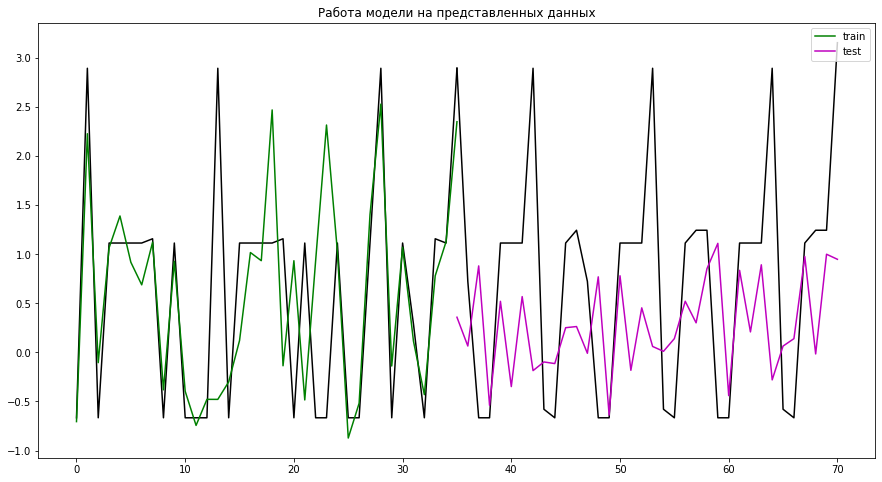

In [157]:
y_pred_test = model.predict(testX)
y_pred_train = model.predict(trainX)
plt.figure(figsize=(15,8))
plt.title('Работа модели на представленных данных')
print(f"R2 = {r2_score(y_test,y_pred_test)}")
print(f"MAE = {mean_absolute_error(y_test,y_pred_test)}")

plt.plot(range(0,3*num_pred),np.hstack((y_train[-3*num_pred+1],y_train[-3*num_pred+1],y_train[-num_pred+1])),'k')
plt.plot(range(0,3*num_pred),np.hstack((y_pred_train[-3*num_pred+1],y_pred_train[-2*num_pred+1],y_pred_train[-num_pred+1])),'g',label = 'train')
plt.plot(range(3*num_pred-1,3*num_pred-1 + 3*num_pred),np.hstack((y_test[0],y_test[1],y_test[2])),'k')
plt.plot(range(3*num_pred-1,3*num_pred-1 + 3*num_pred),np.hstack((y_pred_test[0],y_pred_test[1],y_pred_test[2])),'m',label = 'test')
plt.legend(loc='upper right')
plt.show()

#### 3.5. RandomForest и KNeighbors
Пробуем простые модели множественной регрессии - случайный лес и ближайших соседей

In [125]:
rf = RandomForestRegressor(n_estimators=500,max_depth=10,).fit(X_train,y_train)
y_pred_test = rf.predict(X_test)
y_pred_train = rf.predict(X_train)
print(f"R2 = {r2_score(y_test,y_pred_test)}")
print(f"MAE = {mean_absolute_error(y_test,y_pred_test)}")

R2 = 0.13775375848917684
MAE = 0.941524953966709


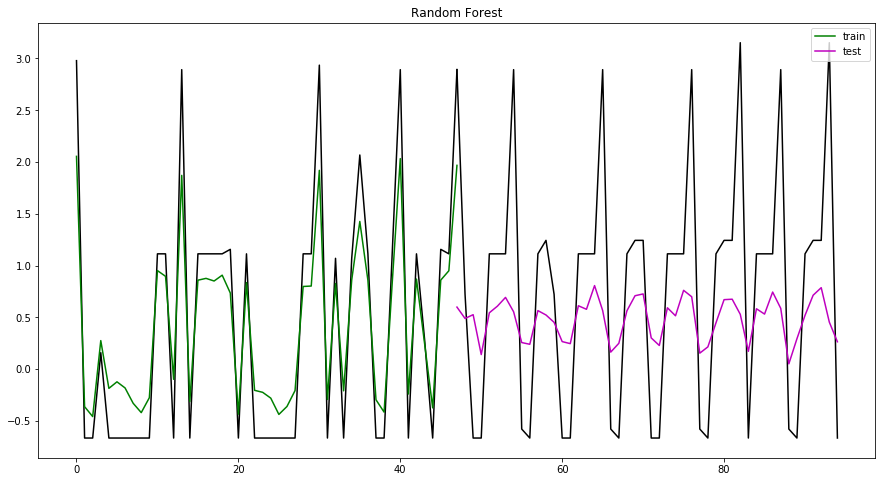

In [126]:
plt.figure(figsize=(15,8))
plt.title('Random Forest')
       
plt.plot(range(0,4*num_pred),np.hstack((y_train[-4*num_pred+1],y_train[-3*num_pred+1],y_train[-2*num_pred+1],y_train[-num_pred+1])),'k')
plt.plot(range(0,4*num_pred),np.hstack((y_pred_train[-4*num_pred+1],y_pred_train[-3*num_pred+1],y_pred_train[-2*num_pred+1],y_pred_train[-num_pred+1])),'g',label = 'train')
plt.plot(range(4*num_pred-1,4*num_pred-1 + 4*num_pred),np.hstack((y_test[0],y_test[1],y_test[2],y_test[3])),'k')
plt.plot(range(4*num_pred-1,4*num_pred-1 + 4*num_pred),np.hstack((y_pred_test[0],y_pred_test[1],y_pred_test[2],y_pred_test[3])),'m',label = 'test')
plt.legend(loc='upper right')
plt.show()

In [127]:
kn = KNeighborsRegressor(n_neighbors=10).fit(X_train,y_train)
y_pred_test = kn.predict(X_test)
y_pred_train = kn.predict(X_train)
print(f"R2 = {r2_score(y_test,y_pred_test)}")
print(f"MAE = {mean_absolute_error(y_test,y_pred_test)}")

R2 = 0.18569533088525436
MAE = 0.8955595006178836


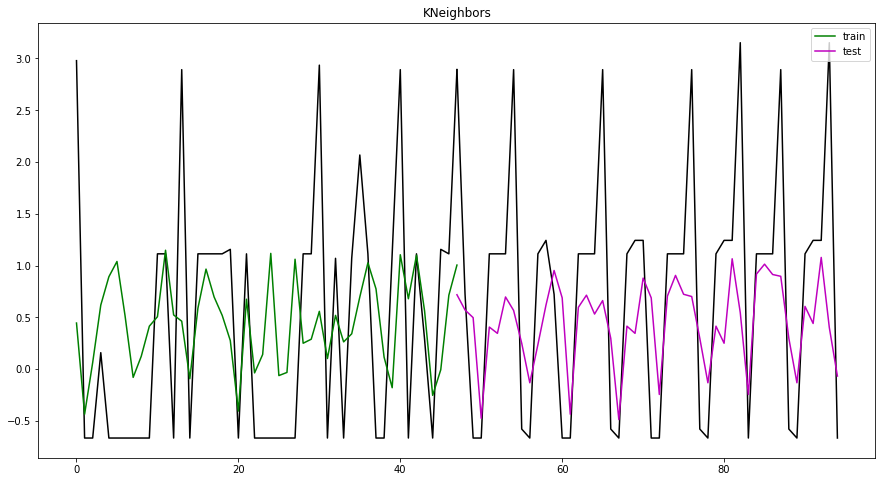

In [128]:
plt.figure(figsize=(15,8))
plt.title('KNeighbors')
       
    
plt.plot(range(0,4*num_pred),np.hstack((y_train[-4*num_pred+1],y_train[-3*num_pred+1],y_train[-2*num_pred+1],y_train[-num_pred+1])),'k')
plt.plot(range(0,4*num_pred),np.hstack((y_pred_train[-4*num_pred+1],y_pred_train[-3*num_pred+1],y_pred_train[-2*num_pred+1],y_pred_train[-num_pred+1])),'g',label = 'train')
plt.plot(range(4*num_pred-1,4*num_pred-1 + 4*num_pred),np.hstack((y_test[0],y_test[1],y_test[2],y_test[3])),'k')
plt.plot(range(4*num_pred-1,4*num_pred-1 + 4*num_pred),np.hstack((y_pred_test[0],y_pred_test[1],y_pred_test[2],y_pred_test[3])),'m',label = 'test')
plt.legend(loc='upper right')
plt.show()

#### 3.6. Предсказание средним и градиентный бустинг
Для сравнения - предсказание средним значением окна:

In [113]:
roll_w = 32
num_pred = 12
test_size = 0.3
tsd = res_data[13]
X_train,X_test,y_train,y_test,scaler = get_train_test_transform_with_intersectioin(tsd,roll_w,num_pred,test_size)

In [114]:
y_pred_test = np.array([x*y for (x,y) in zip(np.ones((X_test.shape[0],12)),X_test.mean(axis = 1))])
y_pred_train = np.array([x*y for (x,y) in zip(np.ones((X_train.shape[0],12)),X_train.mean(axis = 1))])
print(f"R2 = {r2_score(y_test,y_pred_test)}")
print(f"MAE = {mean_absolute_error(y_test,y_pred_test)}")

R2 = -0.08217604080840553
MAE = 1.1442031866220677


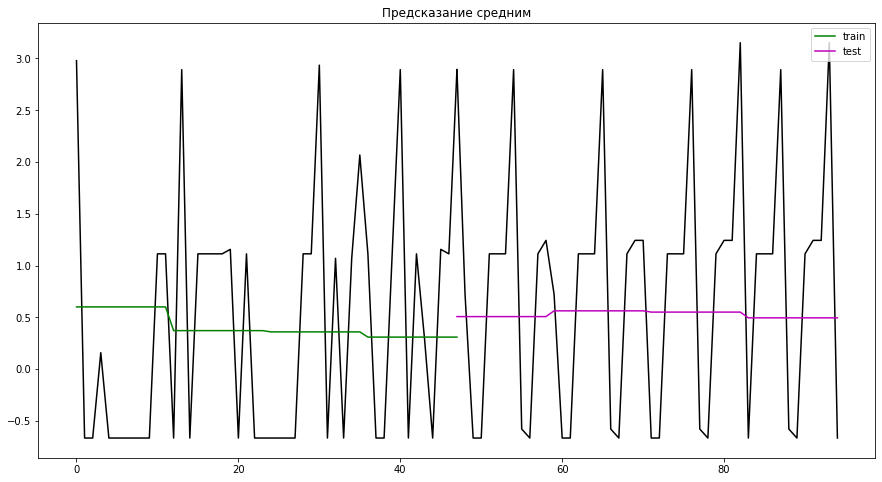

In [115]:
plt.figure(figsize=(15,8))
plt.title('Предсказание средним')
       
plt.plot(range(0,4*num_pred),np.hstack((y_train[-4*num_pred+1],y_train[-3*num_pred+1],y_train[-2*num_pred+1],y_train[-num_pred+1])),'k')
plt.plot(range(0,4*num_pred),np.hstack((y_pred_train[-4*num_pred+1],y_pred_train[-3*num_pred+1],y_pred_train[-2*num_pred+1],y_pred_train[-num_pred+1])),'g',label = 'train')
plt.plot(range(4*num_pred-1,4*num_pred-1 + 4*num_pred),np.hstack((y_test[0],y_test[1],y_test[2],y_test[3])),'k')
plt.plot(range(4*num_pred-1,4*num_pred-1 + 4*num_pred),np.hstack((y_pred_test[0],y_pred_test[1],y_pred_test[2],y_pred_test[3])),'m',label = 'test')
plt.legend(loc='upper right')
plt.show()

Одномерный градиентный бустинг:

In [109]:
roll_w = 32
num_pred = 12
test_size = 0.3
tsd = res_data[13]
X_train,X_test,y_train,y_test,scaler = get_train_test_transform_with_intersectioin(tsd,roll_w,num_pred,test_size)
y_train.shape

(130, 12)

In [110]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

In [121]:
%%time
y_pred_test = np.zeros((y_test.shape))
y_pred_train = np.zeros((y_train.shape))
for dim in tqdm(range(0,y_train.shape[1])):
    gb = GradientBoostingRegressor(n_estimators=50).fit(X_train,y_train[:,dim])
    y_pred_test[:,dim] = gb.predict(X_test)
    y_pred_train[:,dim] = gb.predict(X_train)
print(f"R2 = {r2_score(y_test,y_pred_test)}")
print(f"MAE = {mean_absolute_error(y_test,y_pred_test)}")

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 41.63it/s]


R2 = -0.07866386594646009
MAE = 0.9727328375647154
Wall time: 295 ms


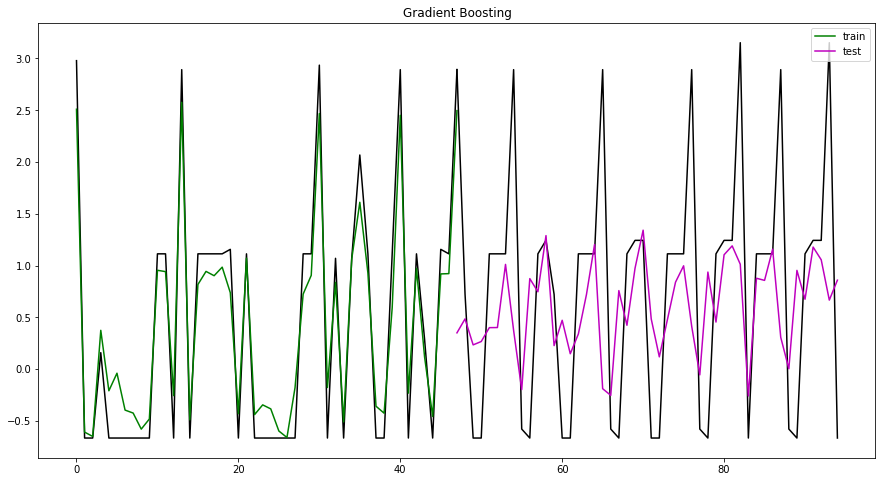

In [122]:
plt.figure(figsize=(15,8))
plt.title('Gradient Boosting')
       
plt.plot(range(0,4*num_pred),np.hstack((y_train[-4*num_pred+1],y_train[-3*num_pred+1],y_train[-2*num_pred+1],y_train[-num_pred+1])),'k')
plt.plot(range(0,4*num_pred),np.hstack((y_pred_train[-4*num_pred+1],y_pred_train[-3*num_pred+1],y_pred_train[-2*num_pred+1],y_pred_train[-num_pred+1])),'g',label = 'train')
plt.plot(range(4*num_pred-1,4*num_pred-1 + 4*num_pred),np.hstack((y_test[0],y_test[1],y_test[2],y_test[3])),'k')
plt.plot(range(4*num_pred-1,4*num_pred-1 + 4*num_pred),np.hstack((y_pred_test[0],y_pred_test[1],y_pred_test[2],y_pred_test[3])),'m',label = 'test')
plt.legend(loc='upper right')
plt.show()

#### 3.7. Визуализация предсказаний
Построим графики и предсказания для 9 случайных рядов и оценим качество их предсказания для моделей случайного леса, ближайших соседей и градиентного бустинга.

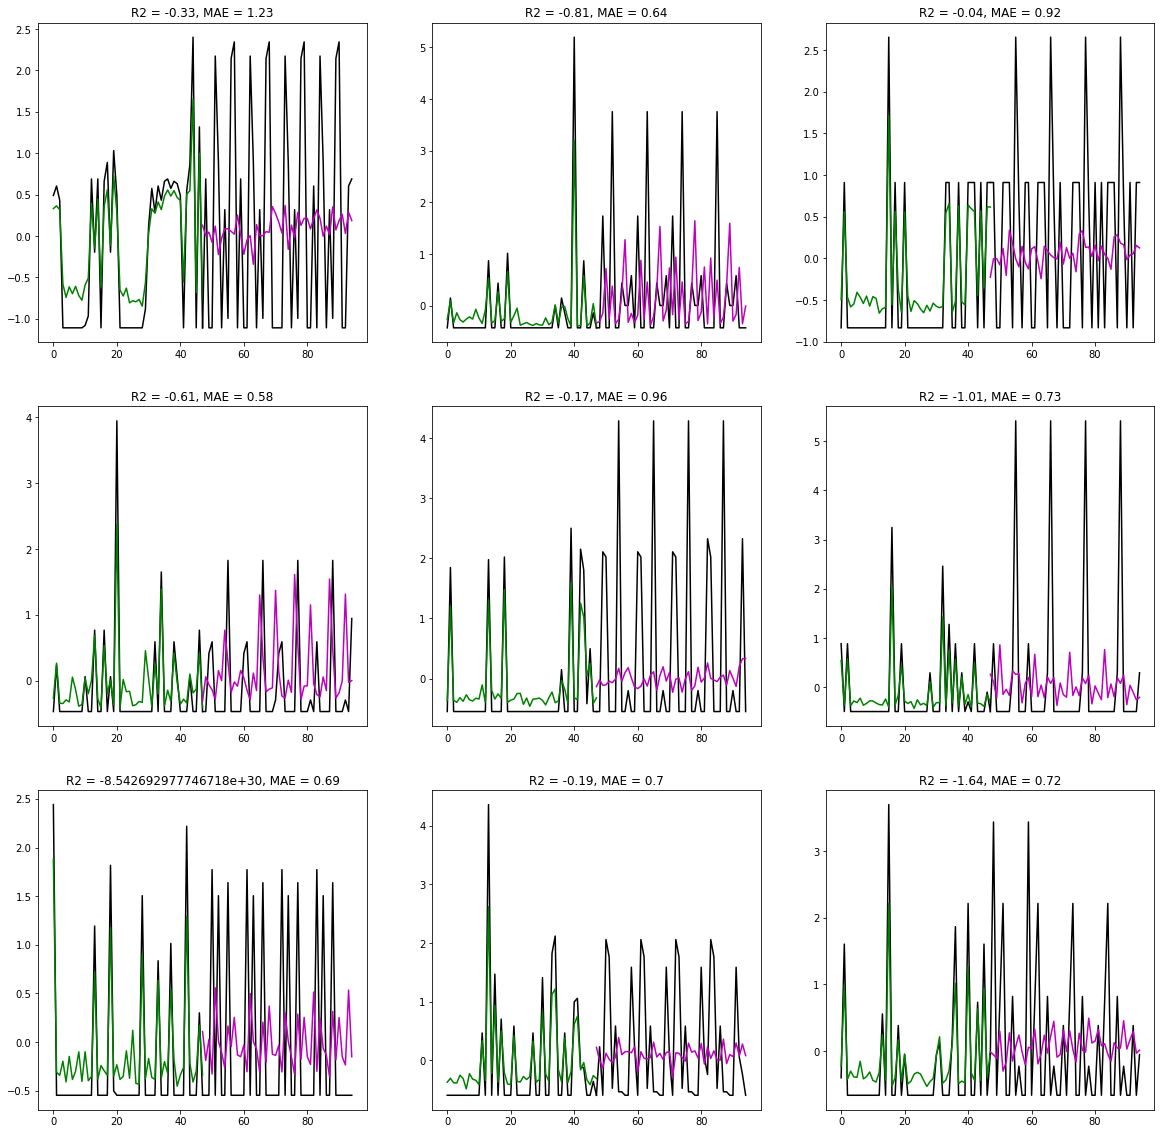

In [137]:
#Пример предсказаний для RandomForest
fig, axes = plt.subplots(nrows=3, ncols=3,figsize = (20,20))
ind = np.random.randint(0,39,9)
for ax in axes.flatten():
    ind = np.random.randint(0,res_data.shape[0])   
    roll_w = 32
    num_pred = 12
    test_size = 0.3
    tsd = res_data[ind]
    X_train,X_test,y_train,y_test,scaler = get_train_test_transform_with_intersectioin(tsd,roll_w,num_pred,test_size)
    est = RandomForestRegressor(n_estimators=1000).fit(X_train,y_train)
    y_pred_test = est.predict(X_test)
    y_pred_train = est.predict(X_train)
    ax.set(title=f'R2 = {np.round(r2_score(y_test,y_pred_test),2)}, MAE = {np.round(mean_absolute_error(y_test,y_pred_test),2)}')
    ax.plot(range(0,4*num_pred),np.hstack((y_train[-4*num_pred+1],y_train[-3*num_pred+1],y_train[-2*num_pred+1],y_train[-num_pred+1])),'k')
    ax.plot(range(0,4*num_pred),np.hstack((y_pred_train[-4*num_pred+1],y_pred_train[-3*num_pred+1],y_pred_train[-2*num_pred+1],y_pred_train[-num_pred+1])),'g',label = 'train')
    ax.plot(range(4*num_pred-1,4*num_pred-1 + 4*num_pred),np.hstack((y_test[0],y_test[1],y_test[2],y_test[3])),'k')
    ax.plot(range(4*num_pred-1,4*num_pred-1 + 4*num_pred),np.hstack((y_pred_test[0],y_pred_test[1],y_pred_test[2],y_pred_test[3])),'m',label = 'test')

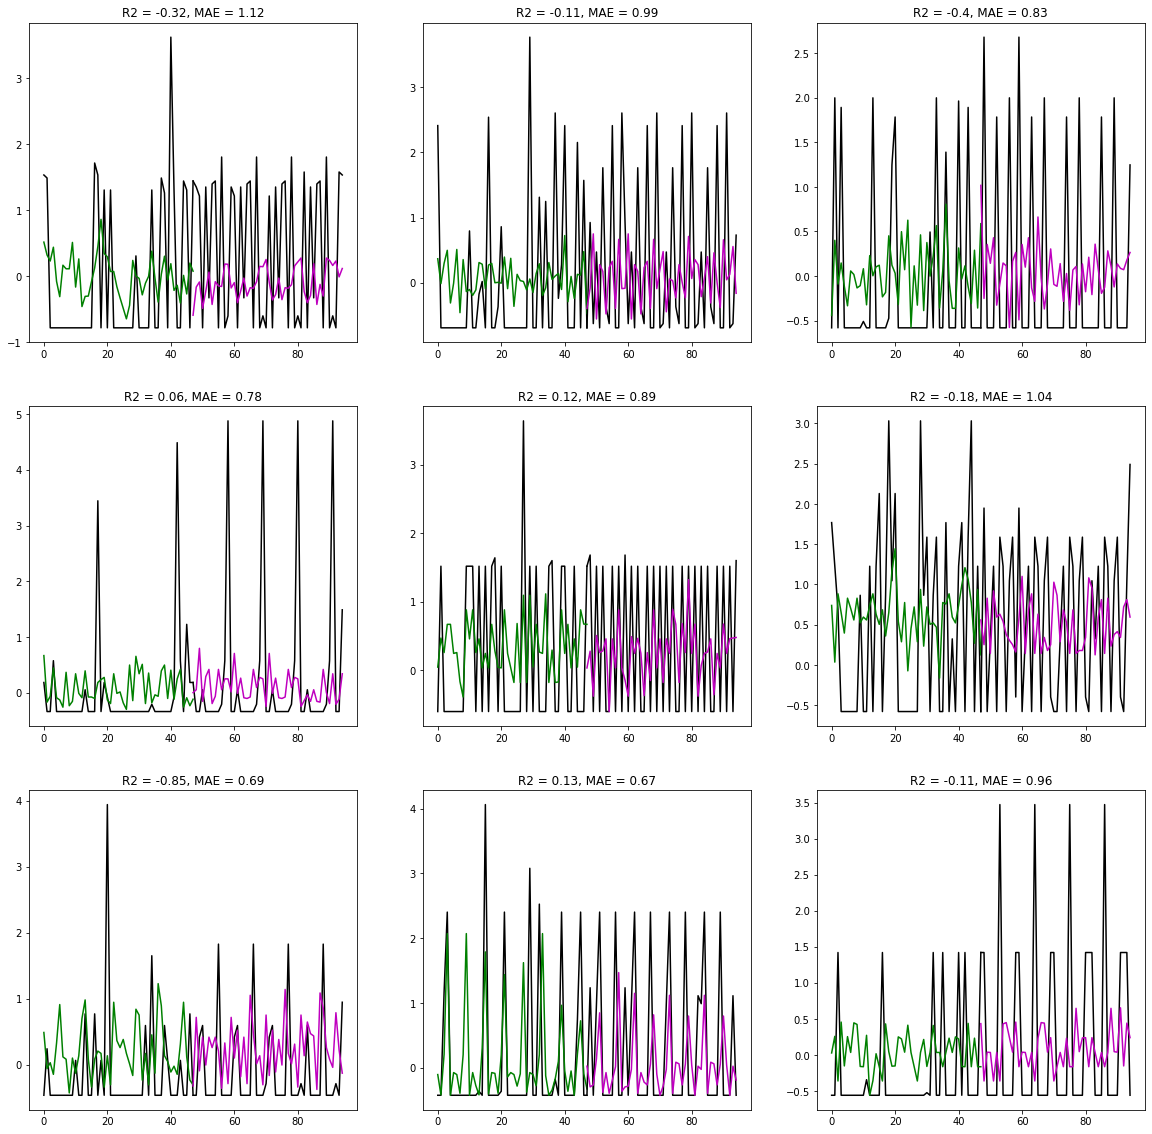

In [138]:
#Пример предсказаний для KNeightboursRegressor
fig, axes = plt.subplots(nrows=3, ncols=3,figsize = (20,20))
ind = np.random.randint(0,39,9)
for ax in axes.flatten():
    ind = np.random.randint(0,res_data.shape[0])   
    roll_w = 32
    num_pred = 12
    test_size = 0.3
    tsd = res_data[ind]
    X_train,X_test,y_train,y_test,scaler = get_train_test_transform_with_intersectioin(tsd,roll_w,num_pred,test_size)
    est = KNeighborsRegressor(n_neighbors=10).fit(X_train,y_train)
    y_pred_test = est.predict(X_test)
    y_pred_train = est.predict(X_train)
    ax.set(title=f'R2 = {np.round(r2_score(y_test,y_pred_test),2)}, MAE = {np.round(mean_absolute_error(y_test,y_pred_test),2)}')
    ax.plot(range(0,4*num_pred),np.hstack((y_train[-4*num_pred+1],y_train[-3*num_pred+1],y_train[-2*num_pred+1],y_train[-num_pred+1])),'k')
    ax.plot(range(0,4*num_pred),np.hstack((y_pred_train[-4*num_pred+1],y_pred_train[-3*num_pred+1],y_pred_train[-2*num_pred+1],y_pred_train[-num_pred+1])),'g',label = 'train')
    ax.plot(range(4*num_pred-1,4*num_pred-1 + 4*num_pred),np.hstack((y_test[0],y_test[1],y_test[2],y_test[3])),'k')
    ax.plot(range(4*num_pred-1,4*num_pred-1 + 4*num_pred),np.hstack((y_pred_test[0],y_pred_test[1],y_pred_test[2],y_pred_test[3])),'m',label = 'test')

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.56it/s]


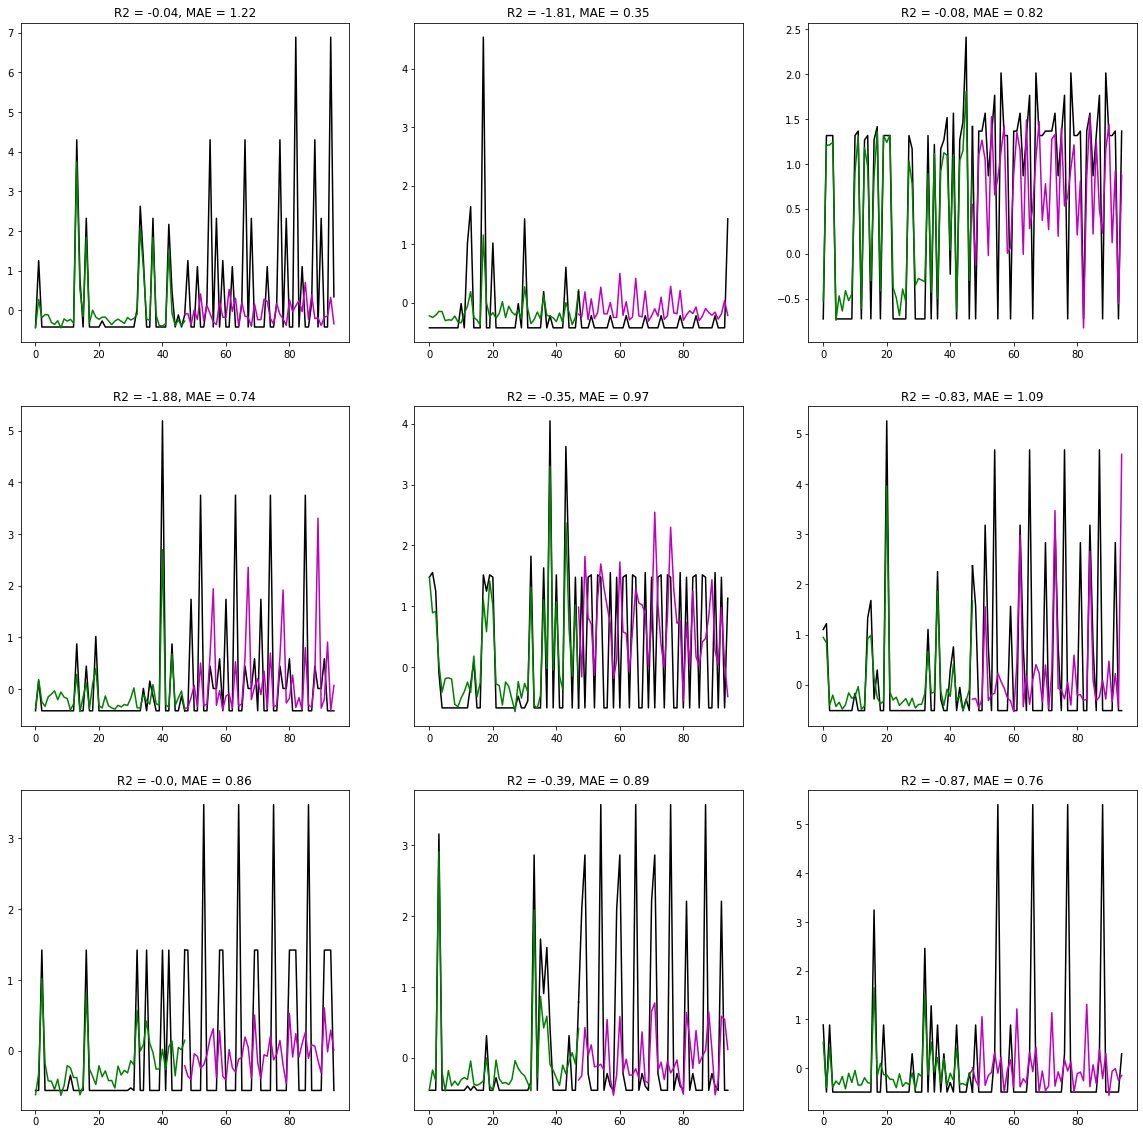

In [135]:
#Пример предсказаний для GradientBoosting
fig, axes = plt.subplots(nrows=3, ncols=3,figsize = (20,20))
ind = np.random.randint(0,39,9)
for ax in axes.flatten():
    ind = np.random.randint(0,res_data.shape[0])   
    roll_w = 32
    num_pred = 12
    test_size = 0.3
    tsd = res_data[ind]
    X_train,X_test,y_train,y_test,scaler = get_train_test_transform_with_intersectioin(tsd,roll_w,num_pred,test_size)
    y_pred_test = np.zeros((y_test.shape))
    y_pred_train = np.zeros((y_train.shape))
    for dim in tqdm(range(0,y_train.shape[1])):
        gb = GradientBoostingRegressor(n_estimators=50).fit(X_train,y_train[:,dim])
        y_pred_test[:,dim] = gb.predict(X_test)
        y_pred_train[:,dim] = gb.predict(X_train)
    ax.set(title=f'R2 = {np.round(r2_score(y_test,y_pred_test),2)}, MAE = {np.round(mean_absolute_error(y_test,y_pred_test),2)}')
    ax.plot(range(0,4*num_pred),np.hstack((y_train[-4*num_pred+1],y_train[-3*num_pred+1],y_train[-2*num_pred+1],y_train[-num_pred+1])),'k')
    ax.plot(range(0,4*num_pred),np.hstack((y_pred_train[-4*num_pred+1],y_pred_train[-3*num_pred+1],y_pred_train[-2*num_pred+1],y_pred_train[-num_pred+1])),'g',label = 'train')
    ax.plot(range(4*num_pred-1,4*num_pred-1 + 4*num_pred),np.hstack((y_test[0],y_test[1],y_test[2],y_test[3])),'k')
    ax.plot(range(4*num_pred-1,4*num_pred-1 + 4*num_pred),np.hstack((y_pred_test[0],y_pred_test[1],y_pred_test[2],y_pred_test[3])),'m',label = 'test')

Применим RandomForest ко всем рядам и сохраним результаты для дальнейшего сравнения с другими моделями.


In [246]:
# Сделаем для всех рядов
r2_all_1dim = []
rmse_all_1dim = []
mae_all_1dim = []
for i in tqdm(range(0,res_data.shape[0])):
    tsd = res_data[i]
    roll_w = 32
    num_pred = 12
    test_size = 0.3
    X_train,X_test,y_train,y_test,scaler = get_train_test_transform_with_intersectioin(tsd,roll_w,num_pred,test_size)
    # Вернем исходный масштаб
    y_train = y_train*scaler.scale_[0]+scaler.mean_[0]
    y_test = y_test*scaler.scale_[0]+scaler.mean_[0]
    # Итоговый регрессор
    rf = RandomForestRegressor(n_estimators=1000,max_depth=10,).fit(X_train,y_train)
    y_pred_test = rf.predict(X_test)
    y_pred_train = rf.predict(X_train)
    r2_all_1dim.append(r2_score(y_test,y_pred_test))
    rmse_all_1dim.append(np.sqrt(mean_squared_error(y_test,y_pred_test)))
    mae_all_1dim.append(mean_absolute_error(y_test,y_pred_test))

100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [01:07<00:00,  1.74s/it]


In [234]:
r2_all_1dim

[-0.028660074774336814,
 -0.06679949728160402,
 -0.07506020950293711,
 -0.2864621207230817,
 -0.18462324468798372,
 0.09672162652687227,
 0.0032095220950092798,
 -0.1801836718811902,
 -7.136037717543942e+30,
 -0.057960369768051294,
 -0.03473644882027841,
 -0.06477562919767337,
 -0.24849961979888016,
 0.11303751672605271,
 -0.27077108337895095,
 -0.2526879158341094,
 -0.018615254866390013,
 -0.05544363749699682,
 -0.7792997754239367,
 -0.6158598469104061,
 -0.04419761507578271,
 -0.6490597001079706,
 -1.3071694317592544,
 -0.33335217553694624,
 -0.19875756849275084,
 0.26889335568345113,
 -2.2567326077596737,
 -0.2763326082625601,
 -0.0514692190573417,
 0.05825391988875502,
 -0.12324235366108459,
 -3.817822670058649e+30,
 -0.06277126470276655,
 -0.2541806423898269,
 -0.26364630150686924,
 -1.1007504562290147,
 -1.8781127369376227,
 -0.175620166798329,
 -0.12611905755328048]

#### 3.8. Выводы по одномерным рядам

Ряд под номером 14 предсказывается рассмотренными моделями лучше чем baseline в виде среднего значения. Но обольщаться не стоит - таких рядов единицы среди рассматриваемых. Данные модели, безусловно, можно улучшить за счет увеличения числа эпох и подбора более сложной архитектуры, но какой это имеет смысл, учитывая, что мы выбрали всего 39 рядов из более 3000 рядов, а нормальную способность для предсказания имеет всего несколько.   
Это наглядно видно по качеству моделей регрессии - $R^2$ в районе 0, а MAE в районе 1, что говорит о том, что средняя ошибка в районе 100%, то есть не сильно лучше, чем предсказывать средним по окну признаков.   
Прдолжим анализ рядов - попробуем найти паттерны за счет кластеризации наших рядов.

### 4. Анализ кластерной структуры данных
В данном разделе перейдем к рассмотрению более широкого круга рядов - с количеством ненулевых записей более 30

In [80]:
from tslearn.generators import random_walks
from tslearn.clustering import TimeSeriesKMeans, silhouette_score

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [81]:
# Извлекаем те ряды, кол-во записей для которых > 30
res = [sum(x>0)>30 for x in data_to_pred[:,2:]]
dpl = data_to_pred[res,:]
X_train = np.array([x[2:] for x in dpl])
X_train.shape

(122, 186)

#### 4.1. Работа с исходными рядами
#### Статистика Хопкинса

Посмотрим на наличие или отсутствие кластерной структуры у имеющихся данных.

In [82]:
# Реализуем проверку наличия кластерной структуры
X = StandardScaler().fit_transform(X_train)
d = X_train.shape[1] # columns
n = X_train.shape[0] # rows
m = int(0.1 * n) # heuristic 

from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(X)

from random import sample
rand_X = sample(range(0, n, 1), m)

ujd = []
wjd = []
for j in range(0, m):
    # ищем расстояние от случайной точки до n_neighbors ближайших соседей
    u_dist, _ = nbrs.kneighbors(np.random.normal(size=(1, d)).reshape(1, -1), n_neighbors=10, return_distance=True)
    ujd.append(u_dist[0][1])
    # расстояние от точки выборки до n_neighbors ближайших соседей
    w_dist, _ = nbrs.kneighbors(X[rand_X[j]].reshape(1, -1), n_neighbors=10, return_distance=True)
    wjd.append(w_dist[0][1])

H = sum(wjd) / (sum(ujd) + sum(wjd))
print(f" Значение статистики Хопкинса: {H}")

 Значение статистики Хопкинса: 0.49580875593794643


Полученное значение статистики меньше, чем 0.5, но и сильно больше 0.25, при которых можно было бы утверждать о тенденции к группированию данных. Продолжим анализ с использованием в качестве метрики коэффициент силуэта.
В качестве функции расстояния будем рассматривать как евклидово, так и dtw.
https://ru.wikipedia.org/wiki/Алгоритм_динамической_трансформации_временной_шкалы
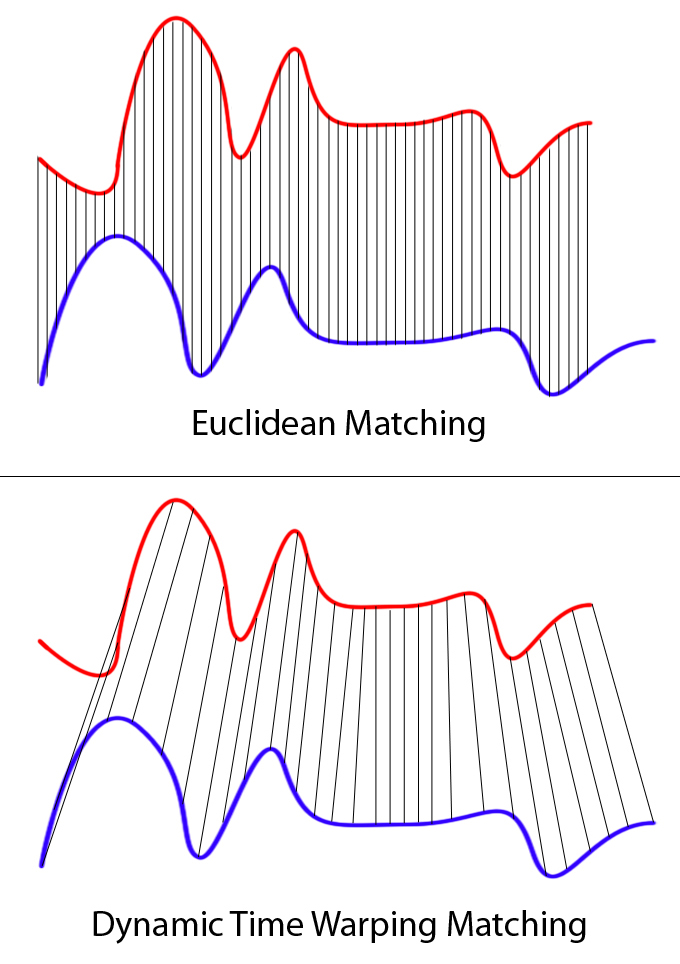
softdtw metrics - https://tslearn.readthedocs.io/en/stable/user_guide/dtw.html#dtw-softdtw

In [83]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans

In [84]:
# Для евклидовой метрики
X = StandardScaler().fit_transform(X_train)
for n_clusters in range(2,10): 
    km = KMeans(n_clusters=n_clusters,  max_iter=10,
                           random_state=0).fit(X)
    y_pred = km.predict(X)
    print(f" Кол-во кластеров: {n_clusters}")
    print(f"Коэффициент силуэта:{silhouette_score(X,y_pred,metric='euclidean')}")
    clust_count = [sum(y_pred==x) for x in range(0,n_clusters)]
    print(f"Объем каждого кластера: {clust_count}")

 Кол-во кластеров: 2
Коэффициент силуэта:0.6417542157108821
Объем каждого кластера: [119, 3]
 Кол-во кластеров: 3
Коэффициент силуэта:0.3651901345808221
Объем каждого кластера: [21, 98, 3]
 Кол-во кластеров: 4
Коэффициент силуэта:0.3438799320260635
Объем каждого кластера: [12, 2, 1, 107]
 Кол-во кластеров: 5
Коэффициент силуэта:0.35244291958572177
Объем каждого кластера: [1, 106, 1, 12, 2]
 Кол-во кластеров: 6
Коэффициент силуэта:0.3303697967838891
Объем каждого кластера: [11, 2, 1, 106, 1, 1]
 Кол-во кластеров: 7
Коэффициент силуэта:0.3465456189569141
Объем каждого кластера: [104, 1, 1, 2, 11, 2, 1]
 Кол-во кластеров: 8
Коэффициент силуэта:0.2866197153610035
Объем каждого кластера: [1, 36, 1, 1, 80, 1, 1, 1]
 Кол-во кластеров: 9
Коэффициент силуэта:0.33042893377795957
Объем каждого кластера: [15, 1, 1, 1, 15, 1, 1, 86, 1]


In [85]:
# Блок с функциями KMeans для временных рядов с метрикой расстояния dtw


import random
import time

def DTWDistance(s1, s2,w):
    DTW={}

    w = max(w, abs(len(s1)-len(s2)))

    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

def LB_Keogh(s1,s2,r):
# The Dynamic Time Warping (DTW) is a popular similarity measure between time series. 
# The DTW fails to satisfy the triangle inequality and its computation requires quadratic  time.  
# Hence,  to  find  closest  neighbors  quickly,  we  use  bounding  tech-niques.
# We can avoid most DTW computations with an inexpensive lower bound (LB Keogh)
    LB_sum=0
    for ind,i in enumerate(s1):

        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])

        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2

    return np.sqrt(LB_sum)


def k_means_clust_dtw(data,num_clust, w=5, min_CentNum=3, min_CentRate=0.1,
                     showAssignments=False, show_excTime=True):
    if show_excTime:
        start_time = time.time()
    centroids = random.sample(list(range(len(data))), num_clust)
    counter = 0
    assignments = {}
    while True:
        counter+=1
        assignments = {}
        for idx in centroids:
            assignments[idx] = [idx]
        #assign data points to clusters
        for idx, ts in enumerate(data):
            if idx in centroids:
                continue
            min_dist = float('inf')
            closest_clust = None
            for c_idx in centroids:
                if LB_Keogh(ts, data[c_idx], w) < min_dist:
                    cur_dist = DTWDistance(ts, data[c_idx], w)
                    if cur_dist < min_dist:
                        min_dist = cur_dist
                        closest_clust = c_idx
            assignments[closest_clust].append(idx)
        #print('Round-{r} Centroids Index : {cents}'.format(r=counter, cents=str(centroids)))
        old_centroids = centroids
        centroids = []
        #print(assignments)
        #recalculate centroids of clusters
        for c_idx in assignments:
            group_members = assignments[c_idx]
            sample_CentNum = max(min_CentNum, int(len(assignments[c_idx])*min_CentRate))
            sample_CentNum = min(sample_CentNum, len(assignments[c_idx]))
            #print('{gid} sample_cen = {sc}'.format(gid=key, sc=sample_cen))
            cent_candidate = random.sample(group_members[1:], sample_CentNum-1)
            
            new_cent = group_members[0]
            err=  0
            for idx in group_members:
                err += DTWDistance(data[new_cent], data[idx], w)
            min_dist = err / len(group_members)
            for i in range(sample_CentNum-1):
                cand_cent = cent_candidate[i]
                err = 0
                for idx in group_members:
                    err += DTWDistance(data[cand_cent], data[idx], w)
                avg_err = err / len(group_members)
                if avg_err < min_dist:
                    new_cent = cent_candidate[i]
                    min_dist = avg_err
            centroids.append(new_cent)
            
        isConvergence = True
        for i in range(num_clust):
            if centroids[i] != old_centroids[i]:
                isConvergence = False
                break
        if isConvergence:
            break
    
    if showAssignments:
        print('\n======== Fianl Assignments ================================')
        for cent_idx in assignments:
            print('{c} : {g}'.format(c=cent_idx, g=str(assignments[cent_idx])))
    #else:
    #    print('\n======== Fianl Centroids ================================')
    #    print('Centroids Index : {cents}'.format(cents=str(list(assignments.keys()))))

    if show_excTime:
        print('\n======== Execution Time =================================')
        print("{t} seconds ".format(t=(time.time()-start_time)))
    
    labels = [0]*(data.shape[0])
    #print(labels)
    i = 0
    for key,item in assignments.items():
        for ind in item:
            labels[ind] = i
        i = i + 1
   
    
    return assignments,np.array(labels)

In [86]:
# Для метрики динамической трансформации времени
X = StandardScaler().fit_transform(X_train).astype('float')
for n_clusters in range(2,10): 
    #km = TimeSeriesKMeans(n_clusters=n_clusters, max_iter=10,metric='dtw',
    #                       random_state=0).fit(X_train)
    groups,labels =  k_means_clust_dtw(X_train,num_clust=n_clusters,w=5,showAssignments=False,show_excTime = False)
    #print(groups)
    y_pred = labels
    print(f" Кол-во кластеров: {n_clusters}")
    print(f"Коэффициент силуэта:{silhouette_score(X,y_pred,metric='dtw')}")
    clust_count = [sum(y_pred==x) for x in range(0,n_clusters)]
    print(f"Объем каждого кластера: {clust_count}")

 Кол-во кластеров: 2
Коэффициент силуэта:0.46892050151469183
Объем каждого кластера: [99, 23]
 Кол-во кластеров: 3
Коэффициент силуэта:0.3739915273097257
Объем каждого кластера: [11, 67, 44]
 Кол-во кластеров: 4
Коэффициент силуэта:0.23757031533881137
Объем каждого кластера: [14, 55, 27, 26]
 Кол-во кластеров: 5
Коэффициент силуэта:0.35589807627658326
Объем каждого кластера: [2, 32, 10, 7, 71]
 Кол-во кластеров: 6
Коэффициент силуэта:0.0728364326412913
Объем каждого кластера: [10, 8, 27, 37, 27, 13]
 Кол-во кластеров: 7
Коэффициент силуэта:0.1796874587193497
Объем каждого кластера: [9, 28, 11, 51, 18, 3, 2]
 Кол-во кластеров: 8
Коэффициент силуэта:0.12135966168898768
Объем каждого кластера: [29, 12, 15, 36, 7, 3, 13, 7]
 Кол-во кластеров: 9
Коэффициент силуэта:0.15110694336514427
Объем каждого кластера: [3, 9, 15, 18, 2, 6, 52, 1, 16]


По большому счету, евклидова метрика нам находит выбросы.

DTW тоже не ахти как работает,но уже дает представление, что разбить надо на 2 кластера - тогда у нас получается два более-менее равномерных по размеру кластера. Посмотрим на них.

In [87]:
groups,labels =  k_means_clust_dtw(X_train,num_clust=2,w=5,showAssignments=False,show_excTime = False)
y_pred = labels
print(f" Кол-во кластеров: {2}")
print(f"Коэффициент силуэта:{silhouette_score(X,y_pred,metric='dtw')}")
clust_count = [sum(y_pred==x) for x in range(0,2)]
print(f"Объем каждого кластера: {clust_count}")

 Кол-во кластеров: 2
Коэффициент силуэта:0.43255645794055286
Объем каждого кластера: [48, 74]


In [88]:
list(groups.keys())

[59, 76]

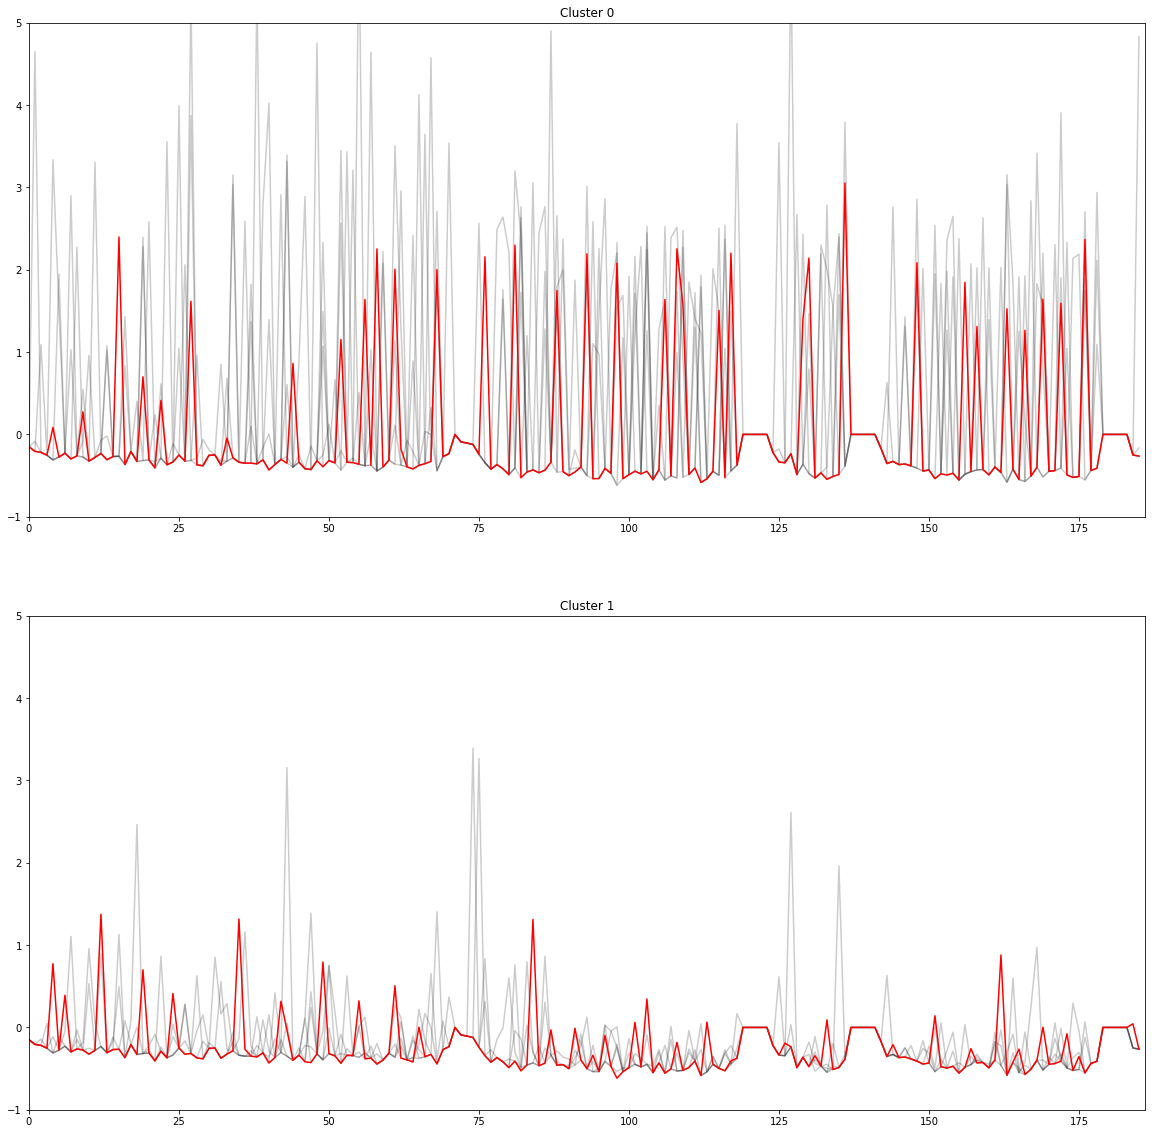

In [89]:
sz = X.shape[1]
plt.figure(figsize = (20,20))
n_clusters = 2
keys = list(groups.keys())
for yi in range(n_clusters):
    plt.subplot(n_clusters, 1, yi + 1)
    for xx in X[y_pred == yi][np.random.randint(X[y_pred == yi].shape[0],size = 5)]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(X[keys[yi]].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-1, 5)
    #plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
     #        transform=plt.gca().transAxes)
    plt.title(f"Cluster {yi}")

Видим, что разделение выходит, в общем-то, по разбросу ряда и его максимальным значениям.

#### 4.2. Кластеризация на новых признаках

Используем библиотеку tsfresh для генерации новых признаков и посмотрим, появляется ли лучшая кластерная структура на новых признаках

In [90]:
# импортируем необходимые функции из библиотеки
from tsfresh.examples.har_dataset import download_har_dataset, load_har_dataset, load_har_classes
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings

In [91]:
settings_minimal = settings.MinimalFCParameters()
settings_minimal
# Набор с временными рядами
settings_time = settings.TimeBasedFCParameters()
#settings_time.update(settings_minimal)
settings_time
# С оконными статистиками 
settings_efficient = settings.EfficientFCParameters()
settings_efficient
# Самый жирный вариант
settings_comprehensive = settings.ComprehensiveFCParameters()
len(settings_comprehensive)

71

In [92]:
# Для начала необходимо перевести наши данные в формат data_long
# Отнормируем данные для начала
X_sc = StandardScaler().fit_transform(X_train)
data_long = pd.DataFrame({'0':X_sc.flatten().astype(float),1:np.arange(X_sc.shape[0]).repeat(X_sc.shape[1])})
data_long.tail()

,0,1
22687,0.000000,121
22688,0.000000,121
22689,0.000000,121
22690,-0.249514,121
22691,3.653488,121


In [93]:
X_fe = extract_features(data_long,impute_function=impute, column_id=1,default_fc_parameters=settings_efficient)
print(X_fe.shape)
X_fe.head()

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.15it/s]


(122, 773)


,0__variance_larger_than_standard_deviation,0__has_duplicate_max,0__has_duplicate_min,0__has_duplicate,0__sum_values,0__abs_energy,0__mean_abs_change,0__mean_change,0__mean_second_derivative_central,0__median,...,0__fourier_entropy__bins_2,0__fourier_entropy__bins_3,0__fourier_entropy__bins_5,0__fourier_entropy__bins_10,0__fourier_entropy__bins_100,0__permutation_entropy__dimension_3__tau_1,0__permutation_entropy__dimension_4__tau_1,0__permutation_entropy__dimension_5__tau_1,0__permutation_entropy__dimension_6__tau_1,0__permutation_entropy__dimension_7__tau_1
0,0.0,0.0,0.0,1.0,-52.589630,22.770027,0.142763,-0.000620,0.000118,-0.335148,...,0.175975,0.295587,0.527853,1.065232,3.077840,1.776947,3.134030,4.308823,4.944734,5.125530
1,1.0,0.0,0.0,1.0,160.773276,808.322185,1.139696,0.005732,0.003311,-0.245436,...,0.058914,0.161651,0.199904,0.461582,2.407436,1.790395,3.136664,4.284496,4.913084,5.069731
2,0.0,0.0,0.0,1.0,-28.249372,54.980057,0.336943,-0.000620,-0.004137,-0.326283,...,0.338886,0.653804,1.144593,1.787151,3.753118,1.768925,3.106259,4.313857,4.935679,5.136138
3,0.0,0.0,0.0,1.0,15.424929,184.517341,0.727294,-0.000620,0.000118,-0.327540,...,0.102967,0.102967,0.552936,0.980411,3.038280,1.783398,3.128115,4.379474,5.011788,5.146747
4,0.0,0.0,0.0,1.0,-14.256230,148.909297,0.489533,-0.000620,0.000118,-0.343299,...,0.381913,0.517929,0.801659,1.384153,3.250977,1.772921,3.110024,4.331586,4.944734,5.120735


In [94]:
# Проверим наличие кластерной структуры по статистке Хопкинса
# Реализуем проверку наличия кластерной структуры
X = StandardScaler().fit_transform(X_fe)
d = X_fe.shape[1] # columns
n = X_fe.shape[0] # rows
m = int(0.1 * n) # heuristic from article [1]

from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(X)

from random import sample
rand_X = sample(range(0, n, 1), m)

ujd = []
wjd = []
for j in range(0, m):
    # ищем расстояние от случайной точки до n_neighbors ближайших соседей
    u_dist, _ = nbrs.kneighbors(np.random.normal(size=(1, d)).reshape(1, -1), n_neighbors=10, return_distance=True)
    ujd.append(u_dist[0][1])
    # расстояние от точки выборки до n_neighbors ближайших соседей
    w_dist, _ = nbrs.kneighbors(X[rand_X[j]].reshape(1, -1), n_neighbors=10, return_distance=True)
    wjd.append(w_dist[0][1])

H = sum(wjd) / (sum(ujd) + sum(wjd))
print(f" Значение статистики Хопкинса: {H}")

 Значение статистики Хопкинса: 0.4497178669380855


Реализуем теперь KMeans на этих признаках


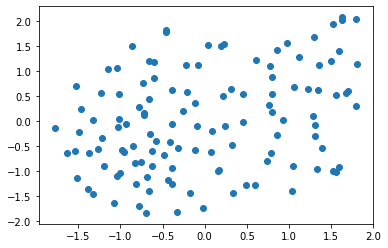

In [95]:
# Понизим размерность 
X_tsne = TSNE(n_components = 2).fit_transform(X_fe)
X_tsne_sc = StandardScaler().fit_transform(X_tsne)
plt.scatter(X_tsne_sc[:,0],X_tsne_sc[:,1])


In [96]:
for n_clusters in range(2,10):
    km = KMeans(n_clusters = n_clusters,n_jobs=-1, random_state = 6,max_iter=10).fit(X_tsne_sc)
    print(f"Кол-во кластеров: {n_clusters}")
    print(f"Коэффициент силуэта: {silhouette_score(X_tsne_sc,km.labels_)}")
    clust_count = [sum(km.labels_==x) for x in range(0,n_clusters)]
    print(f"Объем каждого кластера: {clust_count}")

Кол-во кластеров: 2
Коэффициент силуэта: 0.40645452193604137
Объем каждого кластера: [66, 56]
Кол-во кластеров: 3
Коэффициент силуэта: 0.3830603648119897
Объем каждого кластера: [53, 40, 29]
Кол-во кластеров: 4
Коэффициент силуэта: 0.3996498609312403
Объем каждого кластера: [39, 27, 31, 25]
Кол-во кластеров: 5
Коэффициент силуэта: 0.36117301687577286
Объем каждого кластера: [26, 30, 20, 23, 23]
Кол-во кластеров: 6
Коэффициент силуэта: 0.34422963973716375
Объем каждого кластера: [28, 17, 15, 28, 12, 22]
Кол-во кластеров: 7
Коэффициент силуэта: 0.3684732871309562
Объем каждого кластера: [21, 12, 16, 14, 17, 19, 23]
Кол-во кластеров: 8
Коэффициент силуэта: 0.35405555472315664
Объем каждого кластера: [15, 18, 12, 14, 12, 16, 15, 20]
Кол-во кластеров: 9
Коэффициент силуэта: 0.3498296881743333
Объем каждого кластера: [15, 18, 12, 11, 12, 10, 16, 15, 13]


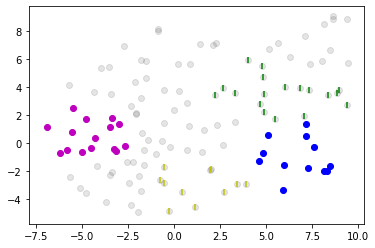

In [97]:
plt.scatter(X_tsne[:,0],X_tsne[:,1],c = 'k', alpha = 0.1)
plt.scatter(X_tsne[km.labels_==0][:,0],X_tsne[km.labels_==0][:,1],c= 'm',marker = 'o')
plt.scatter(X_tsne[km.labels_==1][:,0],X_tsne[km.labels_==1][:,1],c= 'g',marker = '|')
plt.scatter(X_tsne[km.labels_==2][:,0],X_tsne[km.labels_==2][:,1],c= 'b',marker = 'o')
plt.scatter(X_tsne[km.labels_==3][:,0],X_tsne[km.labels_==3][:,1],c= 'y',marker = '|')

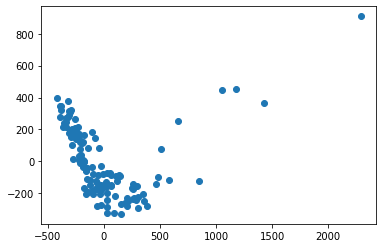

In [98]:
# Понизим размерность PCA
X_pca = PCA(n_components = 2).fit_transform(X_fe)
X_pca_sc = StandardScaler().fit_transform(X_pca)
plt.scatter(X_pca[:,0],X_pca[:,1])

In [99]:
for n_clusters in range(2,10):
    km = KMeans(n_clusters = n_clusters,n_jobs=-1, random_state = 6,max_iter=10).fit(X_pca_sc)
    print(f"Кол-во кластеров: {n_clusters}")
    print(f"Коэффициент силуэта: {silhouette_score(X_pca_sc,km.labels_)}")
    clust_count = [sum(km.labels_==x) for x in range(0,n_clusters)]
    print(f"Объем каждого кластера: {clust_count}")

Кол-во кластеров: 2
Коэффициент силуэта: 0.5024204727766916
Объем каждого кластера: [71, 51]
Кол-во кластеров: 3
Коэффициент силуэта: 0.5627473023139737
Объем каждого кластера: [49, 5, 68]
Кол-во кластеров: 4
Коэффициент силуэта: 0.48493698516973105
Объем каждого кластера: [39, 50, 5, 28]
Кол-во кластеров: 5
Коэффициент силуэта: 0.4876536442092718
Объем каждого кластера: [50, 39, 4, 1, 28]
Кол-во кластеров: 6
Коэффициент силуэта: 0.4494568524580639
Объем каждого кластера: [32, 4, 23, 38, 1, 24]
Кол-во кластеров: 7
Коэффициент силуэта: 0.45442511648996414
Объем каждого кластера: [32, 24, 5, 3, 21, 1, 36]
Кол-во кластеров: 8
Коэффициент силуэта: 0.44590792191277273
Объем каждого кластера: [18, 6, 15, 22, 3, 24, 33, 1]
Кол-во кластеров: 9
Коэффициент силуэта: 0.43841387040974866
Объем каждого кластера: [14, 22, 4, 31, 1, 19, 11, 5, 15]


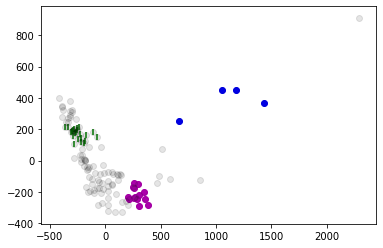

In [100]:
plt.scatter(X_pca[km.labels_==0][:,0],X_pca[km.labels_==0][:,1],c= 'm',marker = 'o')
plt.scatter(X_pca[km.labels_==1][:,0],X_pca[km.labels_==1][:,1],c= 'g',marker = '|')
plt.scatter(X_pca[km.labels_==2][:,0],X_pca[km.labels_==2][:,1],c= 'b',marker = 'o')
plt.scatter(X_pca[:,0],X_pca[:,1],c = 'k', alpha = 0.1)

PCA также не разделяет ряды, но позволяет обнаружить выбросы

#### 4.3. Выводы по кластерному анализу

Наличие кластерной структуры так и не удалось выявить - данные имеют достаточно однородную структуру и при кластеризации разделяются по порогу.
Статистика Хопкинса нас об этом предупреждает как при расчете по временным рядам непосредственно, так и при и ее вычислении по выделенным из рядов признакам с помощью пакета tsfresh.
Новые признаки плюс PCA понижение размерности наводят на мысли о том, что есть выбросы их общей массы рядов.

### 5. Многомерные ряды. Обогащение данных.
Коль с одномерными достаточно грустно, используем два подхода к формированию новых признаков: 

1 - добавим признаки с событийными отметками на станциях;  
2 - заменим наши окна в 32 точки на признаки из tsfresh.   

#### 5.1. Обогащение событийными данными

Добавляем новые ряды с данными по событиям на станциях отпарвления-назначения


In [159]:
def get_roll_data_ndim(data,roll_window,num_pred):
    '''
    data - временной ряд , np.array
    roll_window - размер окна для предсказания, int
    num_pred - кол-во предсказываемых позиций, int
    return нарезанный по окнам ряд с метками для предсказаний
    '''
    ind_start = roll_window
    ind_stop = data.shape[1] - roll_window - num_pred
    data_roll = np.zeros((ind_stop+1,roll_window,9))
    labels_roll = np.zeros((1,num_pred))
    for i in range(0,ind_stop+1):
        data_roll[i,:,:] = np.array(data[:,i:i+roll_window]).astype(float).T.reshape((roll_window,9))
        labels_roll = np.vstack((labels_roll,np.array(data[0,i+roll_window:i+roll_window+num_pred]).astype(float).reshape((1,num_pred))))
    return data_roll,labels_roll[1:]


In [160]:
def get_train_test_transform_with_intersectioin_ndim(data,roll_window,num_pred,test_size):
    '''
    Функция режет временной ряд на интервалы без train и test с пересечением - возможна утечка данных 
    
    args:
    data - временной ряд, используются позиции с 3-ей 
    считается что две первые позиции - зарезервированы под ключи ряда по операциям
    roll_window - размер окна для обучения
    num_pred - кол-во предсказываемых последовательных позиций ряда
    test_size - размер выборки под валидацию
    
    return X_train,X_test,y_train,y_test,sc
    sc - использованный обученный StandatScaler
    
    '''
    dt = data
    #print(data.shape[1])
    data_train = dt[:,:int(data.shape[1]*(1-test_size))+roll_window+num_pred-1]
    data_test = dt[:,int(data.shape[1]*(1-test_size)):]
    #print(data_train.shape,data_test.shape)
    #print(dt.shape)
    #print(int(data.shape[0]*(1-test_size)))
    sc = StandardScaler()
    data_train_sc = sc.fit_transform(data_train.T).T
    data_test_sc = sc.transform(data_test.T).T
    #print(data_train_sc.shape,data_test_sc.shape)
    # блок нарезки на окна
    X_train,y_train = get_roll_data_ndim(data_train_sc,roll_window,num_pred)
    X_test,y_test = get_roll_data_ndim(data_test_sc,roll_window,num_pred)
    return X_train,X_test,y_train,y_test,sc

In [161]:
#X_train,X_test,y_train,y_test,scaler = get_train_test_transform_without_intersectioin(tsd,32,12,0.3)
roll_w = 32
num_pred = 12
test_size = 0.3
tsd = ndim_data[13]

X_train,X_test,y_train,y_test,scaler = get_train_test_transform_with_intersectioin_ndim(tsd,roll_w,num_pred,test_size)
#X_train,X_test,y_train,y_test,scaler = get_train_test_transform_without_intersectioin(tsd,roll_w,num_pred,test_size)
#print(X_train)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(130, 32, 9) (13, 32, 9)
(130, 12) (13, 12)


In [162]:
# Теперь конструируем сеть для этих трехмерных рядов
trainX = X_train
testX = X_test
print(trainX.shape)

(130, 32, 9)


#### 5.2. LSTM на событийных рядах

In [163]:
%%time
# create and fit the LSTM network
model = keras.models.Sequential()
model.add(keras.layers.Input(batch_shape=(1,32,9)))

model.add(keras.layers.LSTM(20,stateful=True,return_sequences=True,activation='relu'))
model.add(keras.layers.Dropout(0.3))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(256,activation = 'relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(12,activation=None))

optim = keras.optimizers.Adam(learning_rate = 1e-3)

model.compile(loss='mse',optimizer = optim,metrics=['MAE'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 32, 20)               2400      
_________________________________________________________________
dropout_6 (Dropout)          (1, 32, 20)               0         
_________________________________________________________________
flatten_3 (Flatten)          (1, 640)                  0         
_________________________________________________________________
dense_8 (Dense)              (1, 256)                  164096    
_________________________________________________________________
dropout_7 (Dropout)          (1, 256)                  0         
_________________________________________________________________
dense_9 (Dense)              (1, 12)                   3084      
Total params: 169,580
Trainable params: 169,580
Non-trainable params: 0
________________________________________________

In [164]:
epochs = 40
history = model.fit(trainX, y_train, epochs=epochs, batch_size=1, verbose=2,validation_data=(testX,y_test))

Epoch 1/40
130/130 - 6s - loss: 1.1400 - MAE: 0.8789 - val_loss: 1.6891 - val_MAE: 1.1475
Epoch 2/40
130/130 - 6s - loss: 1.0044 - MAE: 0.8269 - val_loss: 1.6606 - val_MAE: 1.1283
Epoch 3/40
130/130 - 5s - loss: 0.9747 - MAE: 0.8091 - val_loss: 1.6014 - val_MAE: 1.1096
Epoch 4/40
130/130 - 5s - loss: 0.9351 - MAE: 0.7985 - val_loss: 1.5353 - val_MAE: 1.0694
Epoch 5/40
130/130 - 6s - loss: 0.8868 - MAE: 0.7638 - val_loss: 1.5109 - val_MAE: 1.0475
Epoch 6/40
130/130 - 5s - loss: 0.8254 - MAE: 0.7159 - val_loss: 1.3973 - val_MAE: 0.9604
Epoch 7/40
130/130 - 5s - loss: 0.7830 - MAE: 0.6851 - val_loss: 1.3307 - val_MAE: 0.9154
Epoch 8/40
130/130 - 5s - loss: 0.6900 - MAE: 0.6339 - val_loss: 1.2723 - val_MAE: 0.8773
Epoch 9/40
130/130 - 5s - loss: 0.6577 - MAE: 0.6122 - val_loss: 1.1971 - val_MAE: 0.8263
Epoch 10/40
130/130 - 5s - loss: 0.6339 - MAE: 0.5997 - val_loss: 1.2975 - val_MAE: 0.8666
Epoch 11/40
130/130 - 5s - loss: 0.5663 - MAE: 0.5605 - val_loss: 1.1865 - val_MAE: 0.8174
Epoch 12

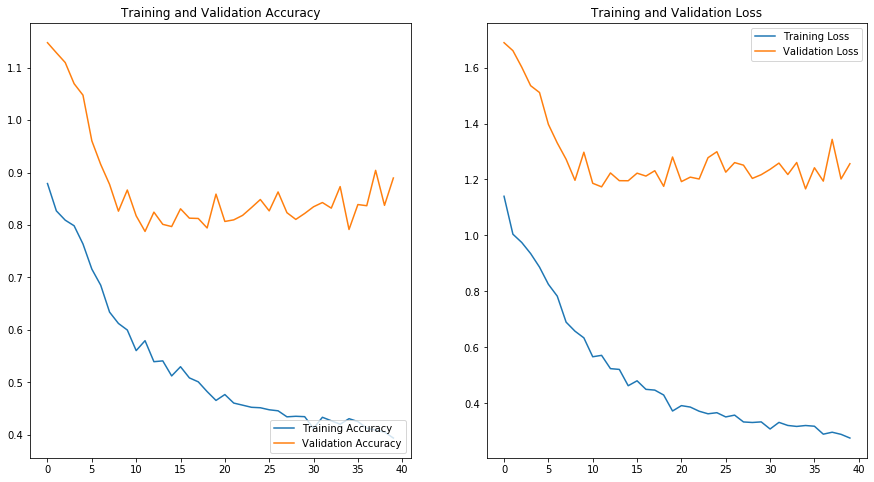

In [165]:
plot_history(history,epochs,metrics = "MAE")

In [166]:
# Структра данных и предсказаний
print(testX.shape)
trainX[100][np.newaxis,:,:]
model.predict(trainX[100][np.newaxis,:,:])

(13, 32, 9)


array([[ 0.74807525,  1.1381049 ,  0.8526441 , -0.51925254,  0.6396901 ,
        -0.2700805 , -0.46313074, -0.48901808, -0.31418058, -0.48863035,
        -0.36685872,  0.8230305 ]], dtype=float32)

In [168]:
y_pred_test = [model.predict(testX[i][np.newaxis,:,:]) for i in range(0,testX.shape[0])]
y_pred_train = [model.predict(trainX[i][np.newaxis,:,:]) for i in range(0,trainX.shape[0])]
print(f"R2 = {r2_score(y_test,np.array(y_pred_test).reshape(y_test.shape))}")
print(f"MAE = {mean_absolute_error(y_test,np.array(y_pred_test).reshape(y_test.shape))}")

R2 = 0.1902329765835005
MAE = 0.8893027847922101


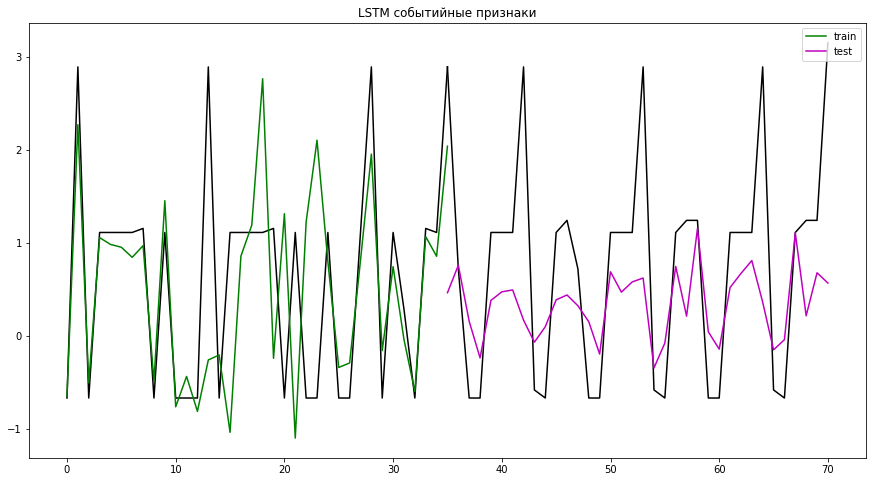

In [110]:
plt.figure(figsize=(15,8))
plt.title('LSTM событийные признаки')
    
plt.plot(range(0,3*num_pred),np.hstack((y_train[-3*num_pred+1],y_train[-3*num_pred+1],y_train[-num_pred+1])),'k')
plt.plot(range(0,3*num_pred),np.hstack((y_pred_train[-3*num_pred+1],y_pred_train[-2*num_pred+1],y_pred_train[-num_pred+1])).reshape((36,)),'g',label = 'train')
plt.plot(range(3*num_pred-1,3*num_pred-1 + 3*num_pred),np.hstack((y_test[0],y_test[1],y_test[2])),'k')
plt.plot(range(3*num_pred-1,3*num_pred-1 + 3*num_pred),np.hstack((y_pred_test[0],y_pred_test[1],y_pred_test[2])).reshape((36,)),'m',label = 'test')
plt.legend(loc='upper right')
plt.show()

Как видим, с LSTM c добавлением новых признаков особо ситуация не изменяется. Пока с нейронными сетями закончим и перейдем к оценке качества предсказательной способности всех рассматриваемых рядов.

#### 5.3. Random Forest на событийных рядах 
Используем модели случайного леса как самую быструю и не отстающую на этих рядах от нейронных сетей.


In [176]:
tsd = ndim_data[13]
X_train,X_test,y_train,y_test,scaler = get_train_test_transform_with_intersectioin_ndim(tsd,roll_w,num_pred,test_size)
X_tr = X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
X_ts = X_test.reshape((X_test.shape[0],X_test.shape[1]*X_test.shape[2]))

In [177]:
X_tr.shape

(130, 288)

In [178]:
print(scaler.mean_)
print(scaler.scale_)

[15.34682081 50.39884393 41.45086705 16.79768786 16.38728324 50.39884393
 41.45086705 16.79768786 16.38728324]
[23.04747435 57.72645679 48.84142279 21.00397968 21.74165869 57.72645679
 48.84142279 21.00397968 21.74165869]


In [179]:
# Вернем исходный масштаб
y_train = y_train*scaler.scale_[0]+scaler.mean_[0]
y_test = y_test*scaler.scale_[0]+scaler.mean_[0]
# Обучаем случайный лес
rf = RandomForestRegressor(n_estimators=1000,max_depth=10,).fit(X_tr,y_train)
y_pred_test = rf.predict(X_ts)
y_pred_train = rf.predict(X_tr)

print(f"R2 = {r2_score(y_test,y_pred_test)}")
print(f"MAE = {mean_absolute_error(y_test,y_pred_test)}")

R2 = 0.20365657810419704
MAE = 21.11109123168498


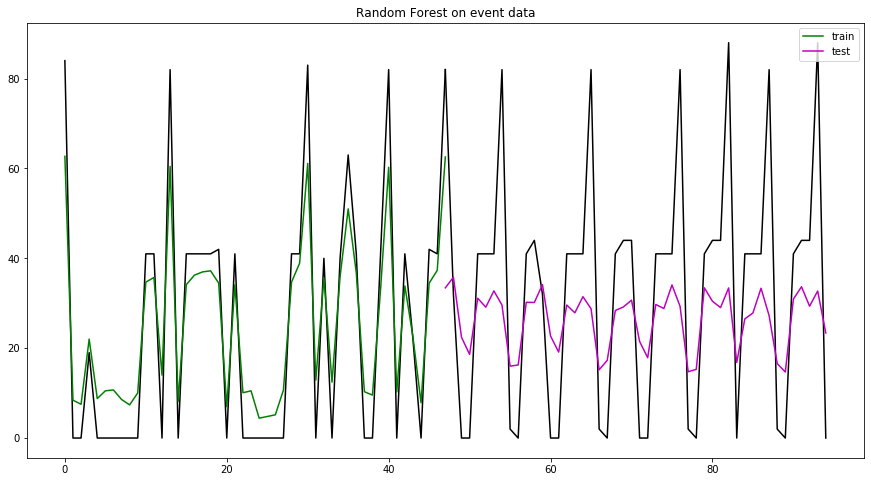

In [180]:
plt.figure(figsize=(15,8))
plt.title('Random Forest on event data')
       
plt.plot(range(0,4*num_pred),np.hstack((y_train[-4*num_pred+1],y_train[-3*num_pred+1],y_train[-2*num_pred+1],y_train[-num_pred+1])),'k')
plt.plot(range(0,4*num_pred),np.hstack((y_pred_train[-4*num_pred+1],y_pred_train[-3*num_pred+1],y_pred_train[-2*num_pred+1],y_pred_train[-num_pred+1])),'g',label = 'train')
plt.plot(range(4*num_pred-1,4*num_pred-1 + 4*num_pred),np.hstack((y_test[0],y_test[1],y_test[2],y_test[3])),'k')
plt.plot(range(4*num_pred-1,4*num_pred-1 + 4*num_pred),np.hstack((y_pred_test[0],y_pred_test[1],y_pred_test[2],y_pred_test[3])),'m',label = 'test')
plt.legend(loc='upper right')
plt.show()

In [184]:
#Отберем лучшие 10 признаков
feat = rf.feature_importances_
best_index = np.argsort(feat)[-10:]

In [185]:
X_tr = X_tr[:,best_index]
X_ts = X_ts[:,best_index]

In [186]:
rf = RandomForestRegressor(n_estimators=1000,max_depth=10,).fit(X_tr,y_train)
y_pred_test = rf.predict(X_ts)
y_pred_train = rf.predict(X_tr)
print(r2_score(y_test,y_pred_test))

0.2075743122610839


Качество почти не изменилось.

Проверим эту модель на всех рядах и вычислим для них $R^{2}$

In [240]:
# Сделаем для всех рядов
r2_all_ev = []
rmse_all_ev = []
mae_all_ev = []
for i in tqdm(range(0,ndim_data.shape[0])):
    tsd = ndim_data[i]
    X_train,X_test,y_train,y_test,scaler = get_train_test_transform_with_intersectioin_ndim(tsd,roll_w,num_pred,test_size)
    X_tr = X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
    X_ts = X_test.reshape((X_test.shape[0],X_test.shape[1]*X_test.shape[2]))

    y_train = y_train*scaler.scale_[0]+scaler.mean_[0]
    y_test = y_test*scaler.scale_[0]+scaler.mean_[0]
    
    rf = RandomForestRegressor(n_estimators=1000).fit(X_tr,y_train)
    y_pred_test = rf.predict(X_ts)
    y_pred_train = rf.predict(X_tr)
    r2_all_ev.append(r2_score(y_test,y_pred_test))
    rmse_all_ev.append(np.sqrt(mean_squared_error(y_pred_test,y_test)))
    mae_all_ev.append(mean_absolute_error(y_test,y_pred_test))

100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [08:56<00:00, 13.76s/it]


In [242]:
r2_all_ev

[-0.026575678415721865,
 -0.027713559797675636,
 -0.03288969377914047,
 -0.3038837485041889,
 -0.12363411252750428,
 -0.026006312575675327,
 -0.05212629953868436,
 -0.05701403893671448,
 -0.14448994786378308,
 -0.09200038548177975,
 0.12687093173393524,
 -0.31040691125546593,
 -0.19530878367650742,
 0.19187495766957333,
 -0.17558056679711057,
 -0.274446379963367,
 -0.06017596192106841,
 -0.0787970807062387,
 -1.4513711430358633,
 -0.19130940639334057,
 -0.10635814557815583,
 -0.5012082893885031,
 -2.0932021209706,
 -0.19745886803217338,
 -0.17654332362151606,
 0.16820187531413322,
 -2.471005289186644,
 0.070074115613994,
 -0.048306066189788645,
 0.032916990174762545,
 -0.14259488416029262,
 -14.175891240426155,
 -0.08552640593896743,
 -0.1189189518485777,
 -0.1439188193075693,
 -5.634620070989609,
 -2.506415422419012,
 -0.073330527604969,
 -0.07978599132031623]

Как можем видеть, ситуация не очень - только 4 ряда из 39 предсказываются лучше, чем простым средним.

#### 5.4. Обогащение данных tsfresh
Провернем другой трюк - с помощью tsfresh поменяем ряды, заменив значения в окнах на автоматически генерируемые признаки

In [188]:
# импортируем необходимые функции из библиотеки
from tsfresh.examples.har_dataset import download_har_dataset, load_har_dataset, load_har_classes
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [189]:
settings_minimal = settings.MinimalFCParameters()
settings_minimal
# Набор с временными рядами
settings_time = settings.TimeBasedFCParameters()
#settings_time.update(settings_minimal)
settings_time
# С оконными статистиками 
settings_efficient = settings.EfficientFCParameters()
settings_efficient
# Самый жирный вариант
settings_comprehensive = settings.ComprehensiveFCParameters()
len(settings_comprehensive)

71

In [190]:
#Берем ряды из X_train,X_test для одномерных и заменяем на признаки из tsfresh
roll_w = 32
num_pred = 12
test_size = 0.3
tsd = res_data[13]
X_train,X_test,y_train,y_test,scaler = get_train_test_transform_with_intersectioin(tsd,roll_w,num_pred,test_size)

In [191]:
y_train.shape

(130, 12)

In [192]:
# Для начала необходимо перевести наши данные в формат data_long
data_long_train = pd.DataFrame({'0':X_train.flatten().astype(float),1:np.arange(X_train.shape[0]).repeat(X_train.shape[1])})
data_long_test = pd.DataFrame({'0':X_test.flatten().astype(float),1:np.arange(X_test.shape[0]).repeat(X_test.shape[1])})
data_long_train.tail()

,0,1
4155,-0.665879,129
4156,1.113058,129
4157,0.288673,129
4158,-0.665879,129
4159,1.156447,129


In [193]:
X_train_fe = extract_features(data_long_train,impute_function=impute, column_id=1,default_fc_parameters=settings_efficient)
X_test_fe = extract_features(data_long_test,impute_function=impute, column_id=1,default_fc_parameters=settings_efficient)
#print(X_fe.shape)
#X_fe.head()

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  6.17it/s]


In [194]:
X_train_fe.head()

,0__variance_larger_than_standard_deviation,0__has_duplicate_max,0__has_duplicate_min,0__has_duplicate,0__sum_values,0__abs_energy,0__mean_abs_change,0__mean_change,0__mean_second_derivative_central,0__median,...,0__fourier_entropy__bins_2,0__fourier_entropy__bins_3,0__fourier_entropy__bins_5,0__fourier_entropy__bins_10,0__fourier_entropy__bins_100,0__permutation_entropy__dimension_3__tau_1,0__permutation_entropy__dimension_4__tau_1,0__permutation_entropy__dimension_5__tau_1,0__permutation_entropy__dimension_6__tau_1,0__permutation_entropy__dimension_7__tau_1
0,0.0,1.0,1.0,1.0,-21.177950,14.020918,0.006998,0.0014,0.000723,-0.665879,...,0.465999,0.956044,1.319730,1.936199,2.670120,0.485094,0.784918,0.949792,1.121136,1.298973
1,0.0,1.0,1.0,1.0,-21.177950,14.020918,0.008398,0.0000,-0.000723,-0.665879,...,0.677494,0.971849,1.517675,2.006955,2.670120,0.562730,0.860914,1.093375,1.266234,1.445250
2,0.0,1.0,1.0,1.0,-21.177950,14.020918,0.008398,0.0000,0.000000,-0.665879,...,0.691416,1.085228,1.579233,2.037734,2.751667,0.639032,0.935343,1.166973,1.409273,1.589122
3,0.0,1.0,1.0,1.0,-21.134562,13.965017,0.009797,0.0014,0.000723,-0.665879,...,0.677494,1.085228,1.513603,2.088502,2.833213,0.639032,1.026171,1.257379,1.498789,1.730428
4,0.0,1.0,1.0,1.0,-21.091173,13.909116,0.009797,0.0014,0.000000,-0.665879,...,0.677494,1.002740,1.486895,1.956187,2.670120,0.639032,1.026171,1.395310,1.637332,1.868984


In [196]:
# Теперь вновь запустим на этих признаках RandomForest
rf = RandomForestRegressor(n_estimators=1000,max_depth=10,).fit(X_train_fe,y_train)
y_pred_test = rf.predict(X_test_fe)
y_pred_train = rf.predict(X_train_fe)
print(f"R2 = {r2_score(y_test,y_pred_test)}")
print(f"MAE = {mean_absolute_error(y_test,y_pred_test)}")

R2 = 0.2909163980726844
MAE = 0.7893581078333303


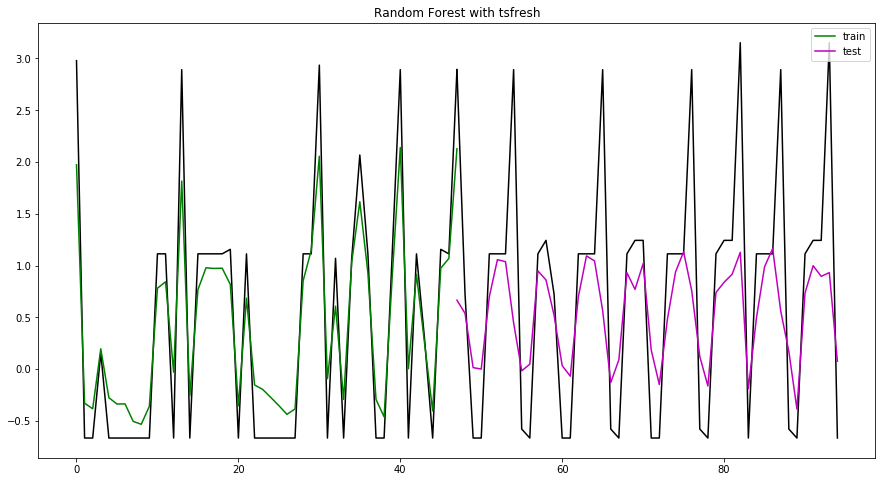

In [129]:
plt.figure(figsize=(15,8))
plt.title('Random Forest with tsfresh')
       
plt.plot(range(0,4*num_pred),np.hstack((y_train[-4*num_pred+1],y_train[-3*num_pred+1],y_train[-2*num_pred+1],y_train[-num_pred+1])),'k')
plt.plot(range(0,4*num_pred),np.hstack((y_pred_train[-4*num_pred+1],y_pred_train[-3*num_pred+1],y_pred_train[-2*num_pred+1],y_pred_train[-num_pred+1])),'g',label = 'train')
plt.plot(range(4*num_pred-1,4*num_pred-1 + 4*num_pred),np.hstack((y_test[0],y_test[1],y_test[2],y_test[3])),'k')
plt.plot(range(4*num_pred-1,4*num_pred-1 + 4*num_pred),np.hstack((y_pred_test[0],y_pred_test[1],y_pred_test[2],y_pred_test[3])),'m',label = 'test')
plt.legend(loc='upper right')
plt.show()

In [197]:
# Отберем 20 лучших признаков
feat = rf.feature_importances_
best_index = np.argsort(feat)[-20:]
X_tr = X_train_fe.values[:,best_index]
X_ts = X_test_fe.values[:,best_index]

rf = RandomForestRegressor(n_estimators=1000,max_depth=10,).fit(X_tr,y_train)
y_pred_test = rf.predict(X_ts)
y_pred_train = rf.predict(X_tr)
print(f"R2 = {r2_score(y_test,y_pred_test)}")
print(f"MAE = {mean_absolute_error(y_test,y_pred_test)}")

R2 = 0.34843855558827225
MAE = 0.7255304586520412


Сильно лучше оно не стало. Но признаки из tsfresh повысили качество нашей модели значительно.

Последнее, что попробуем - сольем признаки от событий и от tsfresh

#### 5.5. Объединение tsfresh и событийных данных


In [198]:
# Признаки от событий
tsd = ndim_data[13]
X_train_ev,X_test_ev,y_train,y_test,scaler = get_train_test_transform_with_intersectioin_ndim(tsd,roll_w,num_pred,test_size)
X_tr = X_train_ev.reshape((X_train_ev.shape[0],X_train_ev.shape[1]*X_train_ev.shape[2]))
X_ts = X_test_ev.reshape((X_test_ev.shape[0],X_test_ev.shape[1]*X_test_ev.shape[2]))
X_tr.shape

(130, 288)

In [199]:
# Объединяем признаки от событий и от tsfresh
X_train_all = np.hstack((X_tr,X_train_fe))
X_test_all = np.hstack((X_ts,X_test_fe))
X_train_all.shape

(130, 1061)

In [200]:
X_train_all

array([[-0.66587864, -0.87306318, -0.84868263, ...,  0.94979166,
         1.12113578,  1.29897286],
       [-0.66587864, -0.87306318, -0.84868263, ...,  1.09337472,
         1.26623389,  1.44525007],
       [-0.66587864, -0.87306318, -0.84868263, ...,  1.16697337,
         1.40927333,  1.58912186],
       ...,
       [-0.66587864,  0.07970619,  0.25693627, ...,  2.69719543,
         2.89510434,  3.02469555],
       [ 2.89199494,  1.30964484,  1.50587613, ...,  2.74670595,
         2.94644857,  3.07801457],
       [-0.66587864,  2.31438345,  1.93583904, ...,  2.79621646,
         2.99779281,  3.13133358]])

In [201]:
# Теперь вновь запустим на этих признаках RandomForest
rf = RandomForestRegressor(n_estimators=1000,max_depth=10,).fit(X_train_all,y_train)
y_pred_test = rf.predict(X_test_all)
y_pred_train = rf.predict(X_train_all)
print(f"R2 = {r2_score(y_test,y_pred_test)}")
print(f"MAE = {mean_absolute_error(y_test,y_pred_test)}")

R2 = 0.2961233801388556
MAE = 0.7888387089312481


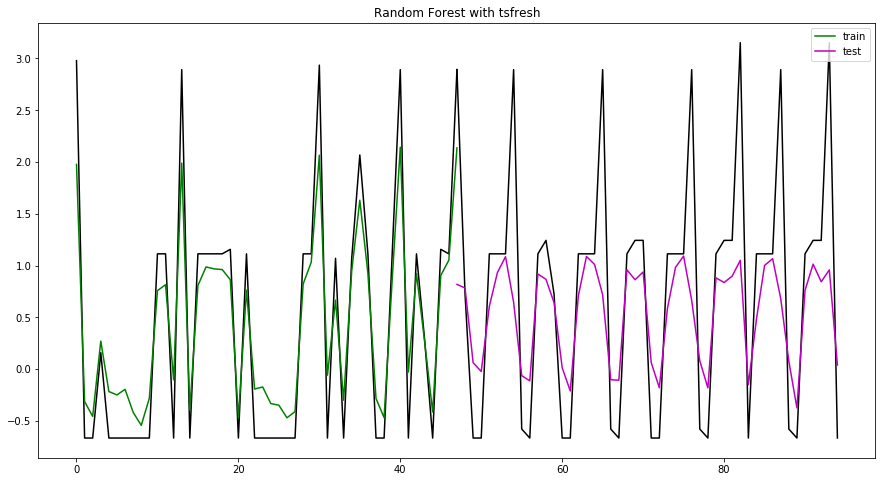

In [135]:
plt.figure(figsize=(15,8))
plt.title('Random Forest with tsfresh')
       
plt.plot(range(0,4*num_pred),np.hstack((y_train[-4*num_pred+1],y_train[-3*num_pred+1],y_train[-2*num_pred+1],y_train[-num_pred+1])),'k')
plt.plot(range(0,4*num_pred),np.hstack((y_pred_train[-4*num_pred+1],y_pred_train[-3*num_pred+1],y_pred_train[-2*num_pred+1],y_pred_train[-num_pred+1])),'g',label = 'train')
plt.plot(range(4*num_pred-1,4*num_pred-1 + 4*num_pred),np.hstack((y_test[0],y_test[1],y_test[2],y_test[3])),'k')
plt.plot(range(4*num_pred-1,4*num_pred-1 + 4*num_pred),np.hstack((y_pred_test[0],y_pred_test[1],y_pred_test[2],y_pred_test[3])),'m',label = 'test')
plt.legend(loc='upper right')
plt.show()

In [202]:
# Отберем 20 лучших признаков и поглядим на итоговый скор
feat = rf.feature_importances_
best_index = np.argsort(feat)[-20:]
X_tr_all = X_train_all[:,best_index]
X_ts_all = X_test_all[:,best_index]

rf_all = RandomForestRegressor(n_estimators=1000,max_depth=10,).fit(X_tr_all,y_train)
y_pred_test = rf_all.predict(X_ts_all)
y_pred_train = rf_all.predict(X_tr_all)
print(f"R2 = {r2_score(y_test,y_pred_test)}")
print(f"MAE = {mean_absolute_error(y_test,y_pred_test)}")

R2 = 0.3710384581498163
MAE = 0.7076380372216312


Определенно, мы добились лучшего результата. Применим этот пайплайн ко всем рассматриваемым рядам.

In [237]:
# Сделаем для всех рядов
r2_all_un = []
rmse_all_un = []
mae_all_un = []
for i in tqdm(range(0,ndim_data.shape[0])):
    # Событийные данные
    tsd = ndim_data[i]
    X_train_ev,X_test_ev,y_train,y_test,scaler = get_train_test_transform_with_intersectioin_ndim(tsd,roll_w,num_pred,test_size)
    X_tr_ev = X_train_ev.reshape((X_train_ev.shape[0],X_train_ev.shape[1]*X_train_ev.shape[2]))
    X_ts_ev = X_test_ev.reshape((X_test_ev.shape[0],X_test_ev.shape[1]*X_test_ev.shape[2]))
    # Данные из tsfresh
    tsd = res_data[i]
    X_train,X_test,y_train,y_test,scaler = get_train_test_transform_with_intersectioin(tsd,roll_w,num_pred,test_size)
    data_long_train = pd.DataFrame({'0':X_train.flatten().astype(float),1:np.arange(X_train.shape[0]).repeat(X_train.shape[1])})
    data_long_test = pd.DataFrame({'0':X_test.flatten().astype(float),1:np.arange(X_test.shape[0]).repeat(X_test.shape[1])})
    X_train_fe = extract_features(data_long_train,impute_function=impute, column_id=1,
                                  default_fc_parameters=settings_efficient,disable_progressbar=True)
    X_test_fe = extract_features(data_long_test,impute_function=impute, column_id=1,
                                 default_fc_parameters=settings_efficient,disable_progressbar=True)
    # Объединяем признаки
    X_train_all = np.hstack((X_tr_ev,X_train_fe))
    X_test_all = np.hstack((X_ts_ev,X_test_fe))
    #Вернем целевые признаки в исходный формат 
    y_train = y_train*scaler.scale_[0]+scaler.mean_[0]
    y_test = y_test*scaler.scale_[0]+scaler.mean_[0]
    # Обучаем первый лес для отбора признаков
    rf_1 = RandomForestRegressor(n_estimators=1000,max_depth=10,).fit(X_train_all,y_train)
    feat = rf_1.feature_importances_
    best_index = np.argsort(feat)[-20:]
    X_tr_all = X_train_all[:,best_index]
    X_ts_all = X_test_all[:,best_index]
    # Итоговый регрессор
    rf_all = RandomForestRegressor(n_estimators=1000,max_depth=10,).fit(X_tr_all,y_train)
    y_pred_test = rf_all.predict(X_ts_all)
    y_pred_train = rf_all.predict(X_tr_all)
    r2_all_un.append(r2_score(y_test,y_pred_test))
    rmse_all_un.append(np.sqrt(mean_squared_error(y_test,y_pred_test)))
    mae_all_un.append(mean_absolute_error(y_test,y_pred_test))

100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [21:00<00:00, 32.32s/it]


#### 5.6. Сравнение результатов для одномерных и обогащенных данных

Сравним результаты по $R^2$ для одномерных и многомерных данных.   
Слева - одномерные, посередине - событийные данные, справа - объединенные данные.

In [243]:
[(x,y,z) for x,y,z in zip(r2_all_1dim,r2_all_ev,r2_all_un)]

[(-0.028660074774336814, -0.026575678415721865, -0.08639979777198419),
 (-0.06679949728160402, -0.027713559797675636, -0.02186728426972127),
 (-0.07506020950293711, -0.03288969377914047, -0.05132545189545831),
 (-0.2864621207230817, -0.3038837485041889, -0.328742906643458),
 (-0.18462324468798372, -0.12363411252750428, -0.09719629116350259),
 (0.09672162652687227, -0.026006312575675327, 0.13954660034405839),
 (0.0032095220950092798, -0.05212629953868436, -0.00151309237358833),
 (-0.1801836718811902, -0.05701403893671448, -0.182489458754737),
 (-7.136037717543942e+30, -0.14448994786378308, -0.17715348531346697),
 (-0.057960369768051294, -0.09200038548177975, -0.07958573345598685),
 (-0.03473644882027841, 0.12687093173393524, -0.023389078667130293),
 (-0.06477562919767337, -0.31040691125546593, -0.12782621059113253),
 (-0.24849961979888016, -0.19530878367650742, -0.4440898885994738),
 (0.11303751672605271, 0.19187495766957333, 0.3492510098712538),
 (-0.27077108337895095, -0.1755805667971

Как видно, улучшить предсказание удалось только для рассматриваемого 14-го ряда, остальные даже ухудшились. В любом случае, адекватной модели для представленных данных обнаружить не удалось.   
Посмотрим также на значения MAE:


In [248]:
[(x,y,z) for x,y,z in zip(mae_all_1dim,mae_all_ev,mae_all_un)]

[(41.62756626287436, 40.713776207994435, 42.09287702802069),
 (5.469190000532843, 5.462104405521072, 5.160551363187499),
 (22.172860775089745, 21.968801282051285, 22.150693045234927),
 (15.530205595364642, 16.318064102564104, 16.895843762722095),
 (26.692097041804686, 25.367583333333332, 25.280776556349633),
 (23.488524021550642, 25.112499999999997, 21.613044421550672),
 (33.63666864679486, 34.99100641025641, 34.926580682481905),
 (22.026414068141452, 21.551262820512818, 22.948849379873277),
 (15.47167990781969, 16.675416666666667, 14.717660830394246),
 (8.040285111101193, 8.23424358974359, 8.206520528356014),
 (25.212620375141423, 24.61175, 24.443602596544107),
 (25.406630848437175, 28.35178846153846, 25.66135843187574),
 (20.14246568986569, 19.86842307692308, 18.125861004273506),
 (21.912143738553112, 21.19552564102564, 16.44381615003586),
 (17.59735195641898, 17.08230128205128, 17.95228712216146),
 (22.67140380009444, 23.457839743589744, 22.482051522966085),
 (14.855561129146738, 15

#### 5.7. Сравнение с gluonts
В ходе анализа были также попытки построить модель с использованием библиотеки gluonts - анализ приведен в ноутбуке Prediction_gluonts

In [139]:
# Сравним с нашими результатами, полученными с помощью gluonts - ноутбук 
rmse_gluonts = [59.5837102420152,
 8.88315009261535,
 27.26017739163375,
 19.39122555909569,
 33.06781982236449,
 35.13411658594449,
 42.0586517976984,
 29.165792123535155,
 18.313826668066582,
 10.212618948225947,
 30.5521330269974,
 49.96521713940044,
 30.530370631287614,
 29.216834934734383,
 27.218259939109917,
 31.064279097247788,
 21.59689542953135,
 25.701709687477504,
 5.589428982029494,
 4.377039188898956,
 45.91099199421355,
 7.936128042203973,
 15.049786572194522,
 45.06890180300607,
 16.672898875731523,
 20.294575111369273,
 3.8811745364459274,
 9.913984378058997,
 8.315966282583375,
 2.946513429889819,
 5.136299729269342,
 2.5869353484183684,
 9.456286026381138,
 39.813871814163406,
 11.919083834745281,
 3.6876217531050473,
 8.872931024331232,
 11.635278621846215,
 55.276820236594205]
print("Сравнение по rmse нашего pipeline с gluonts")
[(x,y) for x,y in zip(rmse_all_un,rmse_gluonts)]

Сравнение по rmse нашего pipeline с gluonts


[(51.27162685451087, 59.5837102420152),
 (6.124588323428499, 8.88315009261535),
 (24.4447262537889, 27.26017739163375),
 (20.850247699631893, 19.39122555909569),
 (26.952810687462495, 33.06781982236449),
 (23.267194081980364, 35.13411658594449),
 (40.39158801344643, 42.0586517976984),
 (30.158354933971836, 29.165792123535155),
 (17.3316831828708, 18.313826668066582),
 (14.370292039212567, 10.212618948225947),
 (32.25763978973482, 30.5521330269974),
 (27.270395098691605, 49.96521713940044),
 (22.31828096690344, 30.530370631287614),
 (23.120491528207555, 29.216834934734383),
 (19.144044373162423, 27.218259939109917),
 (25.962441711273517, 31.064279097247788),
 (18.29150809276235, 21.59689542953135),
 (23.992480327599296, 25.701709687477504),
 (7.639050979204742, 5.589428982029494),
 (5.959230716822987, 4.377039188898956),
 (41.50501361177798, 45.91099199421355),
 (6.046429160233116, 7.936128042203973),
 (11.84247798359897, 15.049786572194522),
 (48.99460064885346, 45.06890180300607),
 (1

Можно видеть, что наш Pipeline близок по качеству к результатам библиотеки gluonts, где-то ее превосходя.   
Но в итоге можно понять, что данные, даже обогащенные tsfresh и событийной информацией по станциям, не позволяют получить качественной модели.
Необходимы данные за более длительный период, а также иное обогащение данных из других источников.

### 6. Общие выводы:
1) Данные являются очень разреженными, поэтому рассматривались только 39 наиболее заполненных ряда.   
2) При этом, треть из рассматриваемых рядов, согласно статистике Льюиса-Бокса, являются случайным шумом, для еще 8 рядов вопрос об их неслучайности под вопросом.   
3) Кластерная структура для данных не обнаружена.   
4) Рассмотрены модели нейронных сетей, случайного леса, ближайших соседей, градиентного бустинга для одномерных и для обогащенных рядов.
Среди 39 рассматриваемых рядов был рассмотрен детально один ряд, который обадает какой-то возможностью к построению модели, предсказывающей будущие значения лучше простого среднего.   
5) Общий вывод - для построения прогнозных моделей для таких рядов явно недостаточно данных за 1 месяц, или же надо продолжать искать признаки среди тех, которые в данном анализе не были рассмотрены, которые позволят добиться построения адекватной модели.   
6) В данном анализе пытались поймать какие-то паттерны, но их не нашлось. Соответственно, для демонстрации этого был выбран $R^2$ в качестве метрики, чтобы показать, что доля объясненной дисперсии не выше, чем предсказание простым средним.
7) Добавление новых признаков повысило качество только для одного ряда, для остальных же результаты существенно не изменились.